In [32]:
# Import packages
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

# Increase resolution of all matplotlib plots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

In [33]:
# Read in cleaned data, neglecting index column
yelp_clean = pd.read_csv('../Data/yelp-clean.csv', low_memory=False).iloc[:, 1:]

# Preprocessing once

In [35]:
# Remove irrelevant features prior to preprocessing
del yelp_clean['name']
del yelp_clean['latitude']
del yelp_clean['longitude']
#del yelp_clean['geometry'] #run if geopandas code cell was run

## Split the data

In [36]:
# Split the iid data
# Since the data is imbalanced (large number of observations with star rating of 3 & 4),
# we should perform stratified splits to ensure that we get a good number of points from
# each of the target groups.

from sklearn.model_selection import train_test_split 
random_state = 77 #set random state for reproducibility

# Define X and y from yelp_clean
y = yelp_clean['star-rating']
X = yelp_clean.loc[:, (yelp_clean.columns != 'star-rating')].copy()

# Specify categorical columns
cat_cols = ['attributes.RestaurantsPriceRange2','city','state','attributes.BYOB',
   'attributes.RestaurantsGoodForGroups','attributes.RestaurantsAttire',
   'attributes.GoodForDancing','attributes.WheelchairAccessible',
   'attributes.RestaurantsTakeOut','attributes.BusinessAcceptsCreditCards',
   'attributes.ByAppointmentOnly','attributes.CoatCheck','attributes.HasTV',
   'attributes.HappyHour','attributes.Smoking','attributes.OutdoorSeating','is_open',
   'attributes.NoiseLevel','attributes.DriveThru',
   'attributes.RestaurantsReservations','attributes.RestaurantsTableService',
   'attributes.DogsAllowed','attributes.BusinessAcceptsBitcoin',
   'attributes.Alcohol','attributes.Caters','attributes.WiFi',
   'attributes.BYOBCorkage','attributes.Corkage','attributes.AcceptsInsurance',
   'attributes.BikeParking']

# Fill missing data in categorical columns with another category labelled 'missing'
X[cat_cols] = X[cat_cols].fillna(value='missing', axis=0)
# Convert categorical column values to str type
X[cat_cols] = X[cat_cols].astype(str)

# Stratified split of data: 80/10/10
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.8,stratify=y,random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=random_state)

# Print value counts of target variable
print(y_train.value_counts(normalize=True))
print()
print(y_val.value_counts(normalize=True))
print()
print(y_test.value_counts(normalize=True))
print()
print("Training size: ", X_train.shape)
print("Validaiton size: ", X_val.shape)
print("Testing size: ", X_test.shape)

4    0.330673
3    0.319881
2    0.164734
5    0.129463
1    0.055250
Name: star-rating, dtype: float64

4    0.330661
3    0.319841
2    0.164714
5    0.129506
1    0.055278
Name: star-rating, dtype: float64

4    0.330699
3    0.319879
2    0.164761
5    0.129443
1    0.055219
Name: star-rating, dtype: float64

Training size:  (142697, 39)
Validaiton size:  (17837, 39)
Testing size:  (17838, 39)


In [37]:
# Define a "fix" for sklearn's MultiLabelBinarizer to work within a ColumnTransformer
# Source: https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer

from sklearn.base import BaseEstimator, TransformerMixin

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self
    
    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result

In [38]:
# Transform categories column into list of lists composed of strings
# We need this format in order to use MultiLabelBinarizer

# Training
yelp_cat_train = X_train['categories']
cat_col_train = []
for row in yelp_cat_train:
    cat_col_train.append(row.split(', '))
# Validation
yelp_cat_val = X_val['categories']
cat_col_val = []
for row in yelp_cat_val:
    cat_col_val.append(row.split(', '))
# Testing
yelp_cat_test = X_test['categories']
cat_col_test = []
for row in yelp_cat_test:
    cat_col_test.append(row.split(', '))
    
# Replace old categories column with the new one

# Training
del X_train['categories']
X_train.loc[:,"categories"] = cat_col_train
# Validation
del X_val['categories']
X_val.loc[:,"categories"] = cat_col_val
# Testing
del X_test['categories']
X_test.loc[:,"categories"] = cat_col_test

In [39]:
# Preprocess X_train, X_val, and X_test

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer
np.random.seed(77)

# Collect types of features
ordinal_fts = ['attributes.RestaurantsPriceRange2']
ordinal_cats = [['missing','None','1','2','3','4']]
onehot_fts = ['city','state','attributes.BYOB','attributes.RestaurantsGoodForGroups',
              'attributes.RestaurantsAttire','attributes.GoodForDancing',
              'attributes.WheelchairAccessible','attributes.RestaurantsTakeOut',
              'attributes.BusinessAcceptsCreditCards','attributes.ByAppointmentOnly',
              'attributes.CoatCheck','attributes.HasTV','attributes.HappyHour',
              'attributes.Smoking','attributes.OutdoorSeating','is_open',
              'attributes.NoiseLevel','attributes.DriveThru',
              'attributes.RestaurantsReservations','attributes.RestaurantsTableService',
              'attributes.DogsAllowed','attributes.BusinessAcceptsBitcoin',
              'attributes.Alcohol','attributes.Caters','attributes.WiFi',
              'attributes.BYOBCorkage','attributes.Corkage','attributes.AcceptsInsurance',
              'attributes.BikeParking']
mlb_fts = ['categories']
minmax_fts = ['Monday.hrs.open','Tuesday.hrs.open',
              'Wednesday.hrs.open','Thursday.hrs.open','Friday.hrs.open',
             'Saturday.hrs.open','Sunday.hrs.open']
std_fts = ['review_count']

# Collect encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_fts),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_fts),
        ('minmax', MinMaxScaler(), minmax_fts),
        ('std', StandardScaler(), std_fts),
        ('mlb', MultiHotEncoder(), mlb_fts)],
    n_jobs=-1)
clf = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit transform
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

# Extract feature names
feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['onehot'].get_feature_names(onehot_fts)) + \
                preprocessor.transformers_[2][-1] + \
                preprocessor.transformers_[3][-1] + \
                [item for sublist in preprocessor.named_transformers_['mlb'].categories_ for item in sublist]

# Convert preprocessed sets to pandas data frames and label preprocessed features
X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names)
X_val_prep = pd.DataFrame(X_val_prep, columns=feature_names)
X_test_prep = pd.DataFrame(X_test_prep, columns=feature_names)

# Print shapes of preprocessed sets
print("Preprocessed training size: ", X_train_prep.shape)
print("Preprocessed validation size: ", X_val_prep.shape)
print("Preprocessed testing size: ", X_test_prep.shape)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Backshop', 'Market Stalls', 'Mauritius', 'Registry Office', 'Sauna Installation & Repair'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Preprocessed training size:  (142697, 2518)
Preprocessed validation size:  (17837, 2518)
Preprocessed testing size:  (17838, 2518)


## Train on one set only to help determine the best evaluation metric and the best ML algorithms. Tune parameters for algorithms that cannot be called in the MLpipe_multiclass function because they are too computationally expensive

In [51]:
# Calculate different baseline accuracies
y_value_counts = y.value_counts()
print("Zero rate classifier baseline accuracy: ", y_value_counts[4]/sum(y_value_counts))

fracs = []
for i in range(1,6):
    fracs.append(y_value_counts[i]/sum(y_value_counts))
print("Random rate classifier baseline accuracy: ", sum([i**2 for i in fracs]))

Zero rate classifier baseline accuracy:  0.33067409683134125
Random rate classifier baseline accuracy:  0.25861752441230684


In [52]:
from sklearn.utils import class_weight
# Define class weight training dictionary for certain algorithms
train_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
train_dict = {1: train_weights[0],
             2: train_weights[1],
             3: train_weights[2],
             4: train_weights[3],
             5: train_weights[4]}

### K Neighbors - Tune n_neighbors; weights='uniform' (the default) is best

In [36]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

clf_test = KNeighborsClassifier(n_neighbors=50, 
                                n_jobs=-1)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.4230906684584001

[[ 134  344  329  136   42]
 [ 106  749 1475  503  106]
 [  91  623 3255 1500  237]
 [  32  290 2212 2924  441]
 [  36  137  434 1007  695]]


In [37]:
clf_test = KNeighborsClassifier(n_neighbors=60, 
                                n_jobs=-1)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.42174439872102276

[[ 134  331  334  141   45]
 [ 108  705 1517  518   91]
 [  83  604 3283 1504  232]
 [  37  288 2224 2941  409]
 [  38  128  423 1032  688]]


In [38]:
clf_test = KNeighborsClassifier(n_neighbors=70, 
                                n_jobs=-1)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.42162443085499746

[[ 123  332  362  133   35]
 [  99  701 1521  521   97]
 [  74  583 3299 1527  223]
 [  31  279 2240 2954  395]
 [  36  129  433 1026  685]]


### Random Forest - can be tuned with function so only run once here

In [53]:
from sklearn.ensemble import RandomForestClassifier

# Fit the model on a fraction of the points in order to calculate global feature importance
X_train_sample = X_train_prep[120000:142000]
y_train_sample = y_train[120000:142000]
X_test_sample = X_test_prep[6000:7500]
y_test_sample = y_test[6000:7500]

train_weights_rf = class_weight.compute_class_weight('balanced',np.unique(y_train_sample),y_train_sample)
train_dict_rf = {1: train_weights_rf[0],
             2: train_weights_rf[1],
             3: train_weights_rf[2],
             4: train_weights_rf[3],
             5: train_weights_rf[4]}

clf_rf = RandomForestClassifier(max_depth=60, 
                                  n_jobs=-1, 
                                  random_state=7, 
                                  class_weight=train_dict_rf)

clf_rf.fit(X_train_sample, y_train_sample)
y_test_pred = clf_rf.predict(X_test_sample)

print(f1_score(y_test_sample, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test_sample, y_test_pred))

0.44591407001740535

[[ 15  24  23  11   8]
 [ 19  51 121  42  16]
 [ 13  42 251 140  26]
 [  3  18 140 286  41]
 [  9   5  30  82  84]]


In [109]:
# Save the model & predictions used for feature importance:
with open('../results/rf_clf_feature_imp.obj', 'wb') as file:
    pickle.dump(clf_rf, file)
file.close()
with open('../results/rf_clf_y_test_pred_feature_imp.obj', 'wb') as file:
    pickle.dump(y_test_pred, file)
file.close()

#### Plot feature importances provided by scikit-learn's random forest classifier

In [54]:
rf_importances = clf_rf.feature_importances_
top10_ind = np.argsort(rf_importances)[-10:]
top10_val = [rf_importances[i] for i in top10_ind]
top10_fts = X_train_sample.columns[top10_ind]

In [55]:
# Take a look at least important features
least_imp_ind = np.where(rf_importances <= 0)
least_imp_val = rf_importances[least_imp_ind]
least_imp_fts = list(X_train_sample.columns[least_imp_ind])

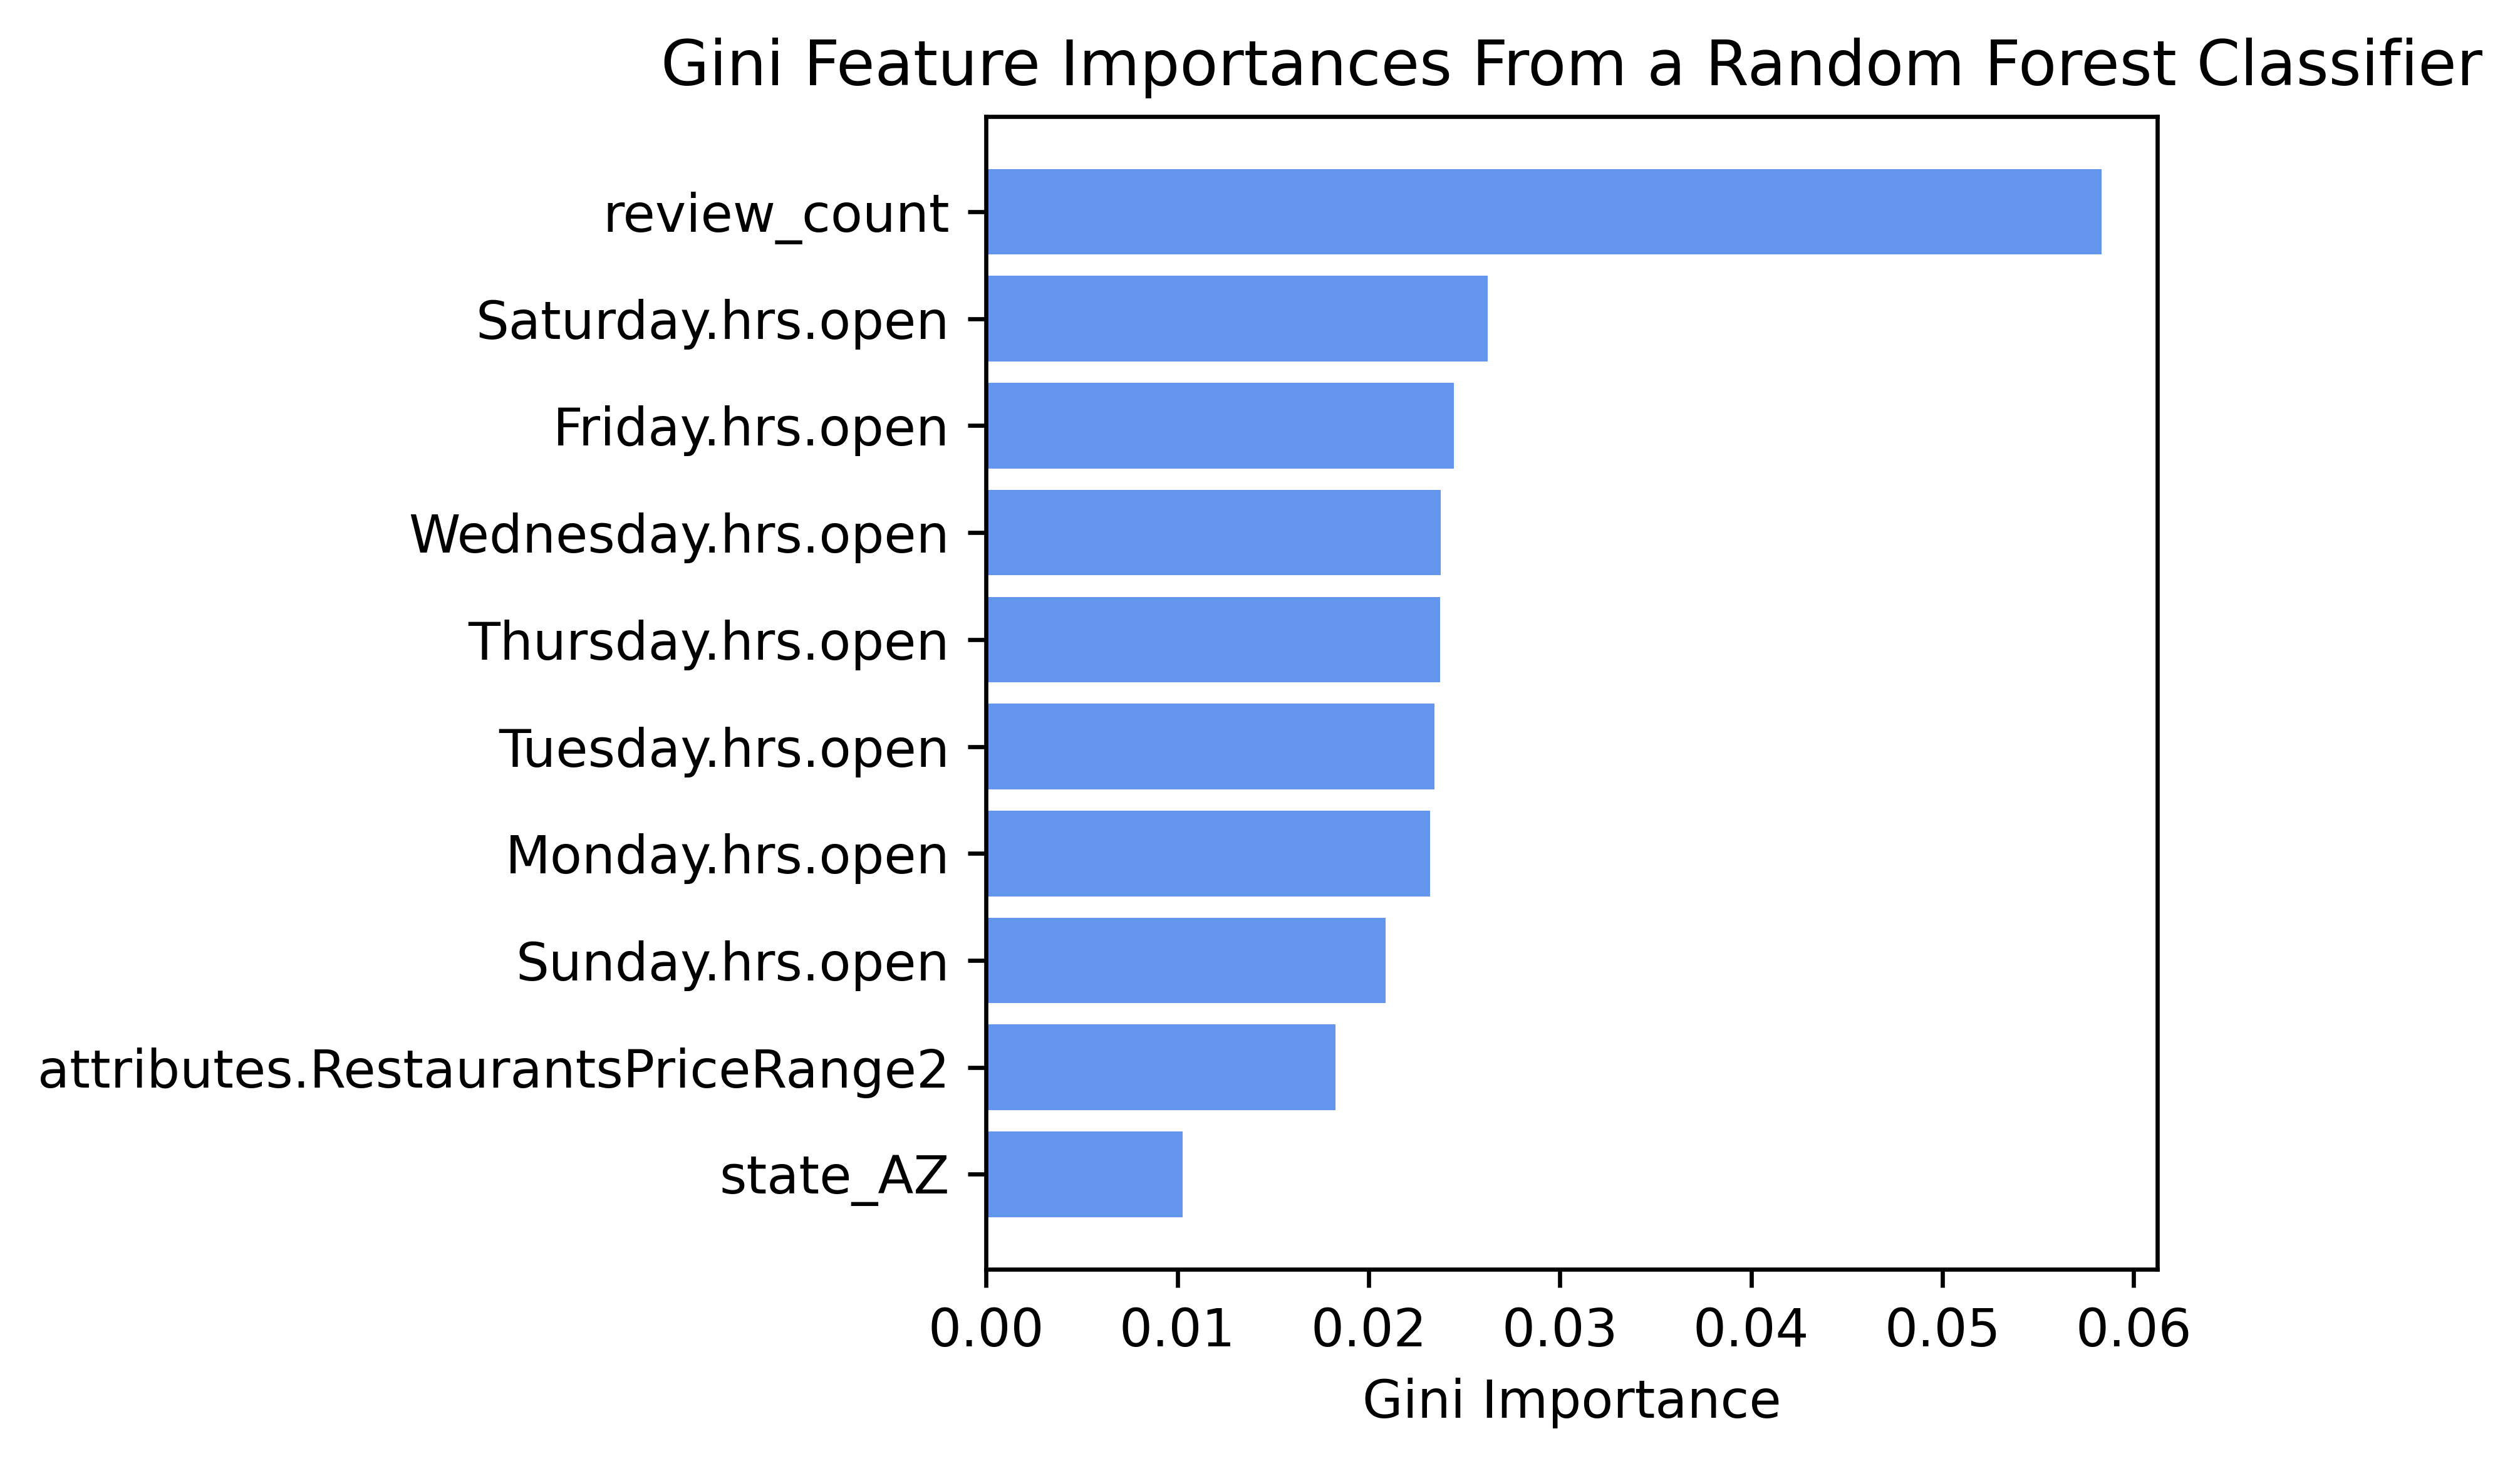

In [56]:
# Plot 10 most important features based on random forest classification importances
plt.barh(y=top10_fts, width=top10_val, color='cornflowerblue')
plt.title("Gini Feature Importances From a Random Forest Classifier")
plt.xlabel("Gini Importance")
plt.tight_layout()
#plt.savefig('../Figures/randomforest-importances.png', bbox_inches='tight')
plt.show()

#### Calculate global feature importances with the above model run on a subset of the data. This will not work on the entire test set (it is too large)

#### Permutation importance

In [57]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(clf_rf, X_test_sample, y_test_sample, n_repeats=5, random_state=77, n_jobs=1)

test_names = list(X_test_sample.columns)

forest_importances = pd.Series(perm_imp.importances_mean, index=test_names)

forest_std = pd.Series(perm_imp.importances_std, index=test_names)

In [58]:
# Take a look at least important features (negative mean accuracy decrease)
low_imp = forest_importances[forest_importances <= 0]
least_imp_labels = list(low_imp.index)

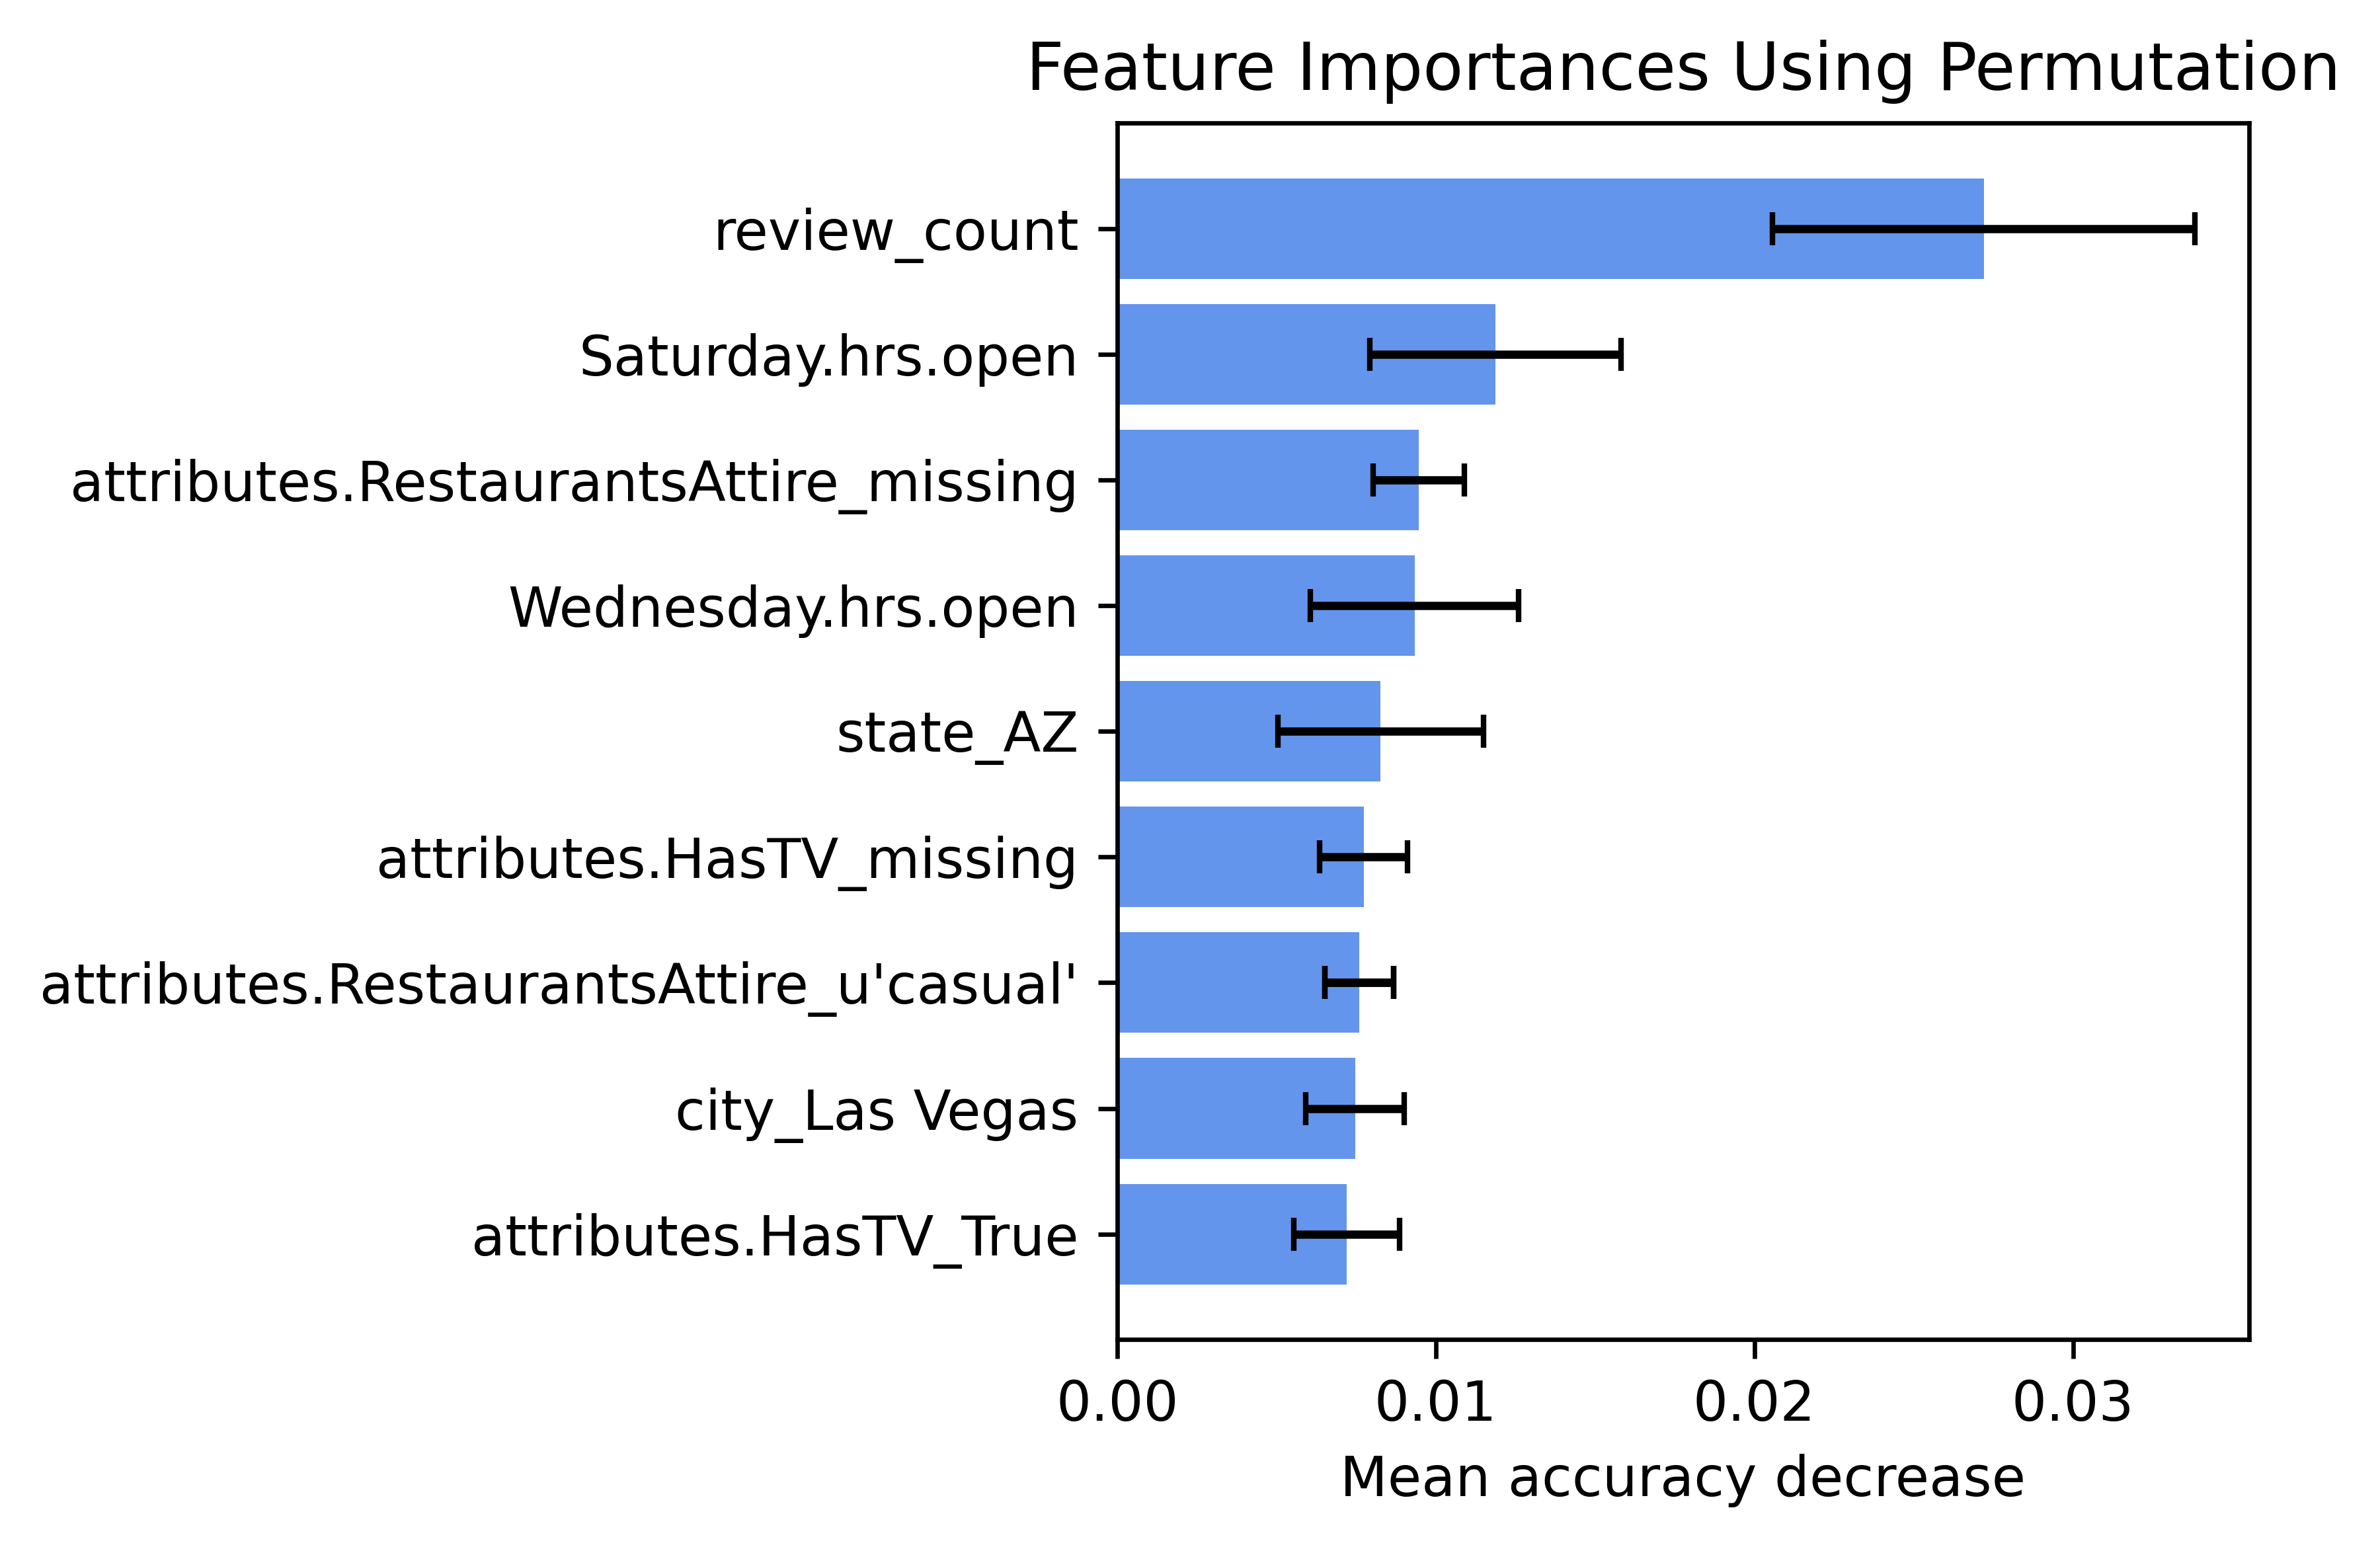

In [59]:
# Take top 10 most important features based on permutation importance on the test set
top10_imp = forest_importances.nlargest(10)
imp_labels = []
for j in range(0,10):
    imp_labels.append(forest_importances[forest_importances==top10_imp[j]].index[0])  
imp_std = []
for l in range(0,10):
    imp_std.append(forest_std[forest_importances==top10_imp[l]][0])

# Plot the most important features
plt.barh(y=imp_labels[::-1], width=top10_imp[::-1], xerr=imp_std[::-1], capsize=3, color='cornflowerblue')
plt.title("Feature Importances Using Permutation")
plt.xlabel("Mean accuracy decrease")
plt.tight_layout()
#plt.savefig('../Figures/permutation-importance.png', bbox_inches='tight')
plt.show()

#### Look at least important features according to intersection from Gini importance and permutation importance

In [60]:
poor_fts = list(set(least_imp_fts) & set(least_imp_labels))
print(len(poor_fts))

# Save list of least important features
with open('../results/least_important_features.obj', 'wb') as file:
    pickle.dump(poor_fts, file)
file.close()

# Create new training and test sets removing least important features
X_train_prep_reduced = X_train_prep.drop(poor_fts, axis='columns')
X_test_prep_reduced = X_test_prep.drop(poor_fts, axis='columns')

690


#### Test same random forest model on reduced feature matrix; see which is better

In [61]:
# Call the same model but with least important features removed

train_weights_rf = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
train_dict_rf = {1: train_weights_rf[0],
             2: train_weights_rf[1],
             3: train_weights_rf[2],
             4: train_weights_rf[3],
             5: train_weights_rf[4]}

clf_rf_reduced = RandomForestClassifier(max_depth=60, 
                                  n_jobs=-1, 
                                  random_state=8, 
                                  class_weight=train_dict_rf)

clf_rf_reduced.fit(X_train_prep_reduced[120000:142000], y_train[120000:142000])
y_test_pred = clf_rf_reduced.predict(X_test_prep_reduced[6000:7500])

print(f1_score(y_test[6000:7500], y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test[6000:7500], y_test_pred))


0.4341911537235421

[[ 13  27  26   7   8]
 [ 18  54 108  53  16]
 [ 13  56 243 130  30]
 [  5  14 140 282  47]
 [  7   9  28  90  76]]


### Linear SVC - tune C

In [40]:
from sklearn.svm import LinearSVC

#param_grid_svc = {'linearsvc__C': [0.5, 1, 10]}

clf_test = LinearSVC(multi_class='crammer_singer', 
                     class_weight=train_dict, 
                     random_state=77, 
                     max_iter=150000, 
                     C=1e-2, 
                     tol=1e-3)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.32824262439646334

[[ 642   63   64   61  155]
 [1162  366  468  487  456]
 [1176  500 1043 1870 1117]
 [ 672  273  573 2395 1986]
 [ 255   66   80  235 1673]]


In [42]:
clf_test = LinearSVC(multi_class='crammer_singer', 
                     class_weight=train_dict, 
                     random_state=77, 
                     max_iter=150000, 
                     C=1e-1, 
                     tol=1e-3)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.33171996667259446

[[ 648   30   95   61  151]
 [1191  196  647  481  424]
 [1199  264 1332 1846 1065]
 [ 715  108  771 2392 1913]
 [ 264   29  116  266 1634]]


In [43]:
clf_test = LinearSVC(multi_class='crammer_singer', 
                     class_weight=train_dict, 
                     random_state=77, 
                     max_iter=150000, 
                     C=1, 
                     tol=1e-3)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.33136632865213106

[[ 645   52   83   64  141]
 [1190  265  593  473  418]
 [1202  377 1261 1819 1047]
 [ 729  188  735 2350 1897]
 [ 269   44  116  257 1623]]


### Ridge Regression Classifier - tune alpha

In [32]:
from sklearn.linear_model import RidgeClassifier

#param_grid_rc = {'ridgeclassifier__alpha': [1e-3, 1e-2, 1e-1, 1]}

clf_test = RidgeClassifier(class_weight=train_dict, 
                           random_state=77, 
                           max_iter=10000, 
                           alpha=1e-3)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.38487042550174916

[[ 579  154   79   45  128]
 [ 990  723  580  274  372]
 [1014  846 1816 1136  894]
 [ 671  426 1049 2091 1662]
 [ 267   97   75  315 1555]]


In [33]:
clf_test = RidgeClassifier(class_weight=train_dict, 
                           random_state=77, 
                           max_iter=10000, 
                           alpha=1e-2)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.3850048467300728

[[ 579  154   79   45  128]
 [ 990  723  580  274  372]
 [1014  847 1816 1135  894]
 [ 671  425 1048 2093 1662]
 [ 267   97   75  315 1555]]


In [34]:
clf_test = RidgeClassifier(class_weight=train_dict, 
                           random_state=77, 
                           max_iter=10000, 
                           alpha=1e-1)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.3853486638054189

[[ 579  155   78   45  128]
 [ 990  726  580  272  371]
 [1016  845 1816 1135  894]
 [ 672  424 1050 2093 1660]
 [ 267   97   75  312 1558]]


In [35]:
clf_test = RidgeClassifier(class_weight=train_dict, 
                           random_state=77, 
                           max_iter=10000, 
                           alpha=1)
clf_test.fit(X_train_prep, y_train)
y_test_pred = clf_test.predict(X_test_prep)
y_val_pred = clf_test.predict(X_val_prep)

print(f1_score(y_test, y_test_pred, average='weighted'))
print()
print(confusion_matrix(y_test, y_test_pred))

0.38563954149410407

[[ 581  154   79   44  127]
 [ 987  724  583  271  374]
 [1015  841 1820 1134  896]
 [ 672  419 1053 2092 1663]
 [ 272   91   75  309 1562]]


# Parameter Tuning

## Define a function to apply various machine learning algorithms. Loop through multiple random states & parameters. User can define a K-fold split and apply cross validation if necessary

In [13]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def MLpipe_multiclass(X, y, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data into training/validation/testing (80/10/10).
    It loops through 5 different random states.
    It accounts for missing values in categorical features by creating a new category 
    labelled 'missing'. 
    The function takes in a pre-define preprocessor and uses GridSearchCV to tune model
    parameters specific to each ML algorithm run on the data.
    CV is "disabled" within GridSearchCV because of the size of the training set.
    Source: https://stackoverflow.com/questions/44636370/scikit-learn-gridsearchcv-without-cross-validation-unsupervised-learning
    '''
    
    num_rand_states = 5
    test_scores = np.zeros(num_rand_states)
    final_models = []
    f1s = []
    
    for i in range(num_rand_states):
        
        np.random.seed(77*i)
        
        # Keep track of which random state we are in (total of 10)
        print("Random state ", i+1)
        
        # Account for missing data in strictly categorical features
        # Specify categorical columns
        cat_cols = ['attributes.RestaurantsPriceRange2','city','state','attributes.BYOB',
                    'attributes.RestaurantsGoodForGroups','attributes.RestaurantsAttire',
                    'attributes.GoodForDancing','attributes.WheelchairAccessible',
                    'attributes.RestaurantsTakeOut','attributes.BusinessAcceptsCreditCards',
                    'attributes.ByAppointmentOnly','attributes.CoatCheck',
                    'attributes.HasTV','attributes.HappyHour','attributes.Smoking',
                    'attributes.OutdoorSeating','is_open','attributes.NoiseLevel',
                    'attributes.DriveThru','attributes.RestaurantsReservations',
                    'attributes.RestaurantsTableService','attributes.DogsAllowed',
                    'attributes.BusinessAcceptsBitcoin','attributes.Alcohol',
                    'attributes.Caters','attributes.WiFi','attributes.BYOBCorkage',
                    'attributes.Corkage','attributes.AcceptsInsurance',
                    'attributes.BikeParking']
        # Fill missing data in categorical columns with another category labelled 'missing'
        X[cat_cols] = X[cat_cols].fillna(value='missing', axis=0)
        # Convert categorical features to str type
        X[cat_cols] = X[cat_cols].astype(str)

        # Stratified split of data: 80/10/10
        X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, stratify=y, random_state=77*i)
        X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, stratify=y_other, random_state=77*i)
        
        # Transform categories column into list of lists composed of strings
        # We need this format in order to use MultiLabelBinarizer
        yelp_cat_train = X_train['categories']
        cat_col_train = []
        for row in yelp_cat_train:
            cat_col_train.append(row.split(', '))
        yelp_cat_val = X_val['categories']
        cat_col_val = []
        for row in yelp_cat_val:
            cat_col_val.append(row.split(', '))
        yelp_cat_test = X_test['categories']
        cat_col_test = []
        for row in yelp_cat_test:
            cat_col_test.append(row.split(', '))

        # Replace old categories column with the new one
        del X_train['categories']
        X_train.loc[:,"categories"] = cat_col_train
        del X_val['categories']
        X_val.loc[:,"categories"] = cat_col_val
        del X_test['categories']
        X_test.loc[:,"categories"] = cat_col_test
        
        # Compute class weights for X_train
        train_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
        weight_dict = {1: train_weights[0],
                      2: train_weights[1],
                      3: train_weights[2],
                      4: train_weights[3],
                      5: train_weights[4]}
        
        # Define K-fold split with 3 folds
        #kf = KFold(n_splits=3, shuffle=True, random_state=77*i)
        
        # Initialize a classifier; parameters dependent on classifier used
        clf = ML_algo(random_state=77*i, class_weight=weight_dict)
        
        # Create the pipeline, Preprocess the data
        pipe = make_pipeline(preprocessor, clf)
        
        # Use grid search CV; can perform cross validation if cv=kf
        # Currently set to no cross validation
        # Source: https://stackoverflow.com/questions/29503689/how-to-run-gridsearchcv-without-cross-validation/29542887#29542887
        grid = GridSearchCV(pipe, 
                            param_grid=param_grid, 
                            scoring='f1_weighted', #Needs to be maximized
                            #cv=kf#ShuffleSplit(test_size=0.20, n_splits=1), #This "disables" CV in GridSearchCV
                            return_train_score=True, 
                            n_jobs=-1, 
                            verbose=10)

        # Fit the model on training data
        grid.fit(X_train, y_train)
        
        # Save the results as a data frame
        results = pd.DataFrame(grid.cv_results_)
        
        # Print parameters and score for best model of each iteration
        print('Best model parameters:', grid.best_params_)
        print('Best validation score:', grid.best_score_)
        
        # Append to list of final models
        final_models.append(grid)
        
        # Calculate test scores after model has been fitted
        y_test_pred = final_models[-1].predict(X_test)
        test_scores[i] = f1_score(y_test, y_test_pred, average='weighted') #weighted F1
        print('Weighted F1 test score:', test_scores[i])
        print()
        print(confusion_matrix(y_test, y_test_pred))
        f1s.append(test_scores[i])
    
    # Print mean and standard deviation of 10 best test scores
    print("Mean of test scores: ", np.mean(f1s))
    print("Standard deviation of test scores: ", np.std(f1s))

## Define preprocessor before calling function

In [72]:
# Define a "fix" for sklearn's MultiLabelBinarizer to work within a ColumnTransformer
# Source: https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self
    
    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result
    
# Collect types of features
ordinal_fts = ['attributes.RestaurantsPriceRange2']
ordinal_cats = [['missing','None','1','2','3','4']]
onehot_fts = ['city','state','attributes.BYOB','attributes.RestaurantsGoodForGroups',
              'attributes.RestaurantsAttire','attributes.GoodForDancing',
              'attributes.WheelchairAccessible','attributes.RestaurantsTakeOut',
              'attributes.BusinessAcceptsCreditCards','attributes.ByAppointmentOnly',
              'attributes.CoatCheck','attributes.HasTV','attributes.HappyHour',
              'attributes.Smoking','attributes.OutdoorSeating','is_open',
              'attributes.NoiseLevel','attributes.DriveThru',
              'attributes.RestaurantsReservations','attributes.RestaurantsTableService',
              'attributes.DogsAllowed','attributes.BusinessAcceptsBitcoin',
              'attributes.Alcohol','attributes.Caters','attributes.WiFi',
              'attributes.BYOBCorkage','attributes.Corkage','attributes.AcceptsInsurance',
              'attributes.BikeParking']
mlb_fts = ['categories']
minmax_fts = ['Monday.hrs.open','Tuesday.hrs.open',
              'Wednesday.hrs.open','Thursday.hrs.open','Friday.hrs.open',
             'Saturday.hrs.open','Sunday.hrs.open']
std_fts = ['review_count']

# Collect encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_fts),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_fts),
        ('minmax', MinMaxScaler(), minmax_fts),
        ('std', StandardScaler(), std_fts),
        ('mlb', MultiHotEncoder(), mlb_fts)],
    n_jobs=-1)

## Try a random forest classifier; tune max_depth

In [23]:
# Unable to suppress warnings that MultiLabelBinarizer outputs
# Discussion on fix: https://github.com/scikit-learn/scikit-learn/issues/10410

from sklearn.ensemble import RandomForestClassifier

param_grid_rfc = {'randomforestclassifier__max_depth': [50, 55, 60]}

MLpipe_multiclass(X, y, preprocessor, RandomForestClassifier, param_grid_rfc)


Random state  1
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=165984    3
103038    4
108520    4
31205     4
152509    4
         ..
53185     3
91153     4
59723     3
28951     3
108100    3
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Art Installation', 'Backshop', 'Concept Shops', 'Customs Brokers', 'Experiences', 'Game Meat', 'Minho', 'Pita', 'Sauna Installation & Repair', 'Sikh Temples', 'Tempura', 'Tonkatsu', 'Waldorf Schools'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/s

Best model parameters: {'randomforestclassifier__max_depth': 60}
Best validation score: 0.44584679951011374


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Bus Stations', 'Eritrean', 'Hearing Aids', 'Sport Equipment Hire'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.4467399369023424

[[ 123  295  324  171   72]
 [ 115  721 1417  538  148]
 [  85  500 3028 1802  291]
 [  38  219 1684 3485  473]
 [  20   99  367  971  852]]
Random state  2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=22573     4
80535     4
4486      2
4144      4
153260    5
         ..
29541     2
124001    5
39672     3
91798     3
121948    3
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Beer Hall', 'Christmas Markets', 'Elevator Services', 'Experiences', 'Game Meat', 'Hang Gliding', 'Japanese Sweets', 'Milkshake Bars', 'Minho', 'Pita', 'Rodeo', 'Soba', 'Speech Training', 'Swiss Food', 'Toxicologists', 'Wildlife Hunting Ranges'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Beer Hall', 'Christmas Markets', 'Elevator Services', 'Experiences', 'Game Meat', 'Hang Gliding', 'Japanese Sweets', 'Milkshake Bars', 'Minho', 'Pita', 'Rodeo', 'Soba', 'Speech Training', 'Swiss Food', 'Toxicologists', 'Wildlife Hunting Ranges'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site

Best model parameters: {'randomforestclassifier__max_depth': 60}
Best validation score: 0.44680658284702696
Weighted F1 test score: 0.44633631862273887

[[ 144  317  301  151   72]
 [ 120  705 1401  572  141]
 [  89  576 2926 1798  317]
 [  35  247 1624 3553  440]
 [  27   91  332  998  861]]
Random state  3


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=20282     4
165016    5
145798    4
137264    2
120976    2
         ..
113025    4
102184    4
101366    4
25929     2
108019    4
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Billing Services', 'Hotel bar', 'Japanese Sweets', 'Kitchen Incubators', 'Paragliding', 'Tempura', 'Tonkatsu', 'Toxicologists', 'Trivia Hosts'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Billing Services', 'Hotel bar', 'Japanese Sweets', 'Kitchen Incubators', 'Paragliding', 'Tempura', 'Tonkatsu', 'Toxicologists', 'Trivia Hosts'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Billing Services', 'Hotel bar', 'Japanese Sweets', 'Kitchen Incubators', 'Paragliding', 'Tempura', 'Tonkatsu', 'Toxicologist

Best model parameters: {'randomforestclassifier__max_depth': 60}
Best validation score: 0.4511165095965664


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Food Safety Training', 'Hainan', 'Hang Gliding', 'Homeopathic', 'Market Stalls', 'Rodeo'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.44970184124961304

[[ 157  294  327  139   68]
 [ 120  759 1358  561  141]
 [  60  552 2927 1863  304]
 [  29  246 1644 3533  447]
 [  17  106  330  999  857]]
Random state  4


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=139823    4
100770    4
143127    2
148735    2
151100    2
         ..
109204    1
129473    2
119866    4
41308     4
165718    4
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Auto Electric Services', 'Beer Garden', 'Bocce Ball', 'Dialysis Clinics', 'Drama Schools', 'Drive-Thru Bars', 'Electricity Suppliers', 'Food Safety Training', 'Homeopathic', 'Hotel bar', 'Milkshake Bars', 'Natural Gas Suppliers', 'Osteopaths', 'Sledding', 'Toxicologists', 'Undersea/Hyperbaric Medicine', 'Waldorf Schools'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Auto Electric Services', 'Beer Garden', 'Bocce Ball', 'Dialysis Clinics', 'Drama Schools', 'Drive-Thru Bars', 'Electricity Suppliers', 'Food Safety Training', 'Homeopathic', 'Hotel bar', 'Milkshake Bars', 'Natural Gas Suppliers', 'Osteopaths', 'Sledding', 'Toxicologists', 'Undersea/Hyperbaric Medicine', 'Wa

Best model parameters: {'randomforestclassifier__max_depth': 55}
Best validation score: 0.447322290493668


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Catalan', 'Stonemasons', 'Tempura', 'Tonkatsu'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.4486086506340567

[[ 142  312  324  154   53]
 [ 119  724 1414  535  147]
 [  80  516 2936 1863  311]
 [  34  203 1635 3573  454]
 [  15   80  317 1035  862]]
Random state  5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=58408     5
94642     3
166511    2
161062    4
144810    4
         ..
26840     2
141037    1
26210     3
117599    2
138094    3
Name: star-rating, Length: 142697, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Beer Garden', 'Billing Services', 'Bungee Jumping', 'Calabrian', 'Concept Shops', 'Hainan', 'Japanese Sweets', 'Kitchen Incubators', 'Nudist', 'Osteopaths', 'Outdoor Movies', 'Sauna Installation & Repair', 'Traditional Clothing'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Beer Garden', 'Billing Services', 'Bungee Jumping', 'Calabrian', 'Concept Shops', 'Hainan', 'Japanese Sweets', 'Kitchen Incubators', 'Nudist', 'Osteopaths', 'Outdoor Movies', 'Sauna Installation & Repair', 'Traditional Clothing'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/

Best model parameters: {'randomforestclassifier__max_depth': 60}
Best validation score: 0.4495140912575645


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Bus Stations', 'Carousels', 'Churros', 'Market Stalls', 'Milkshake Bars', 'Pita', 'Trivia Hosts', 'Udon'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.4466278054347406

[[ 150  286  332  158   59]
 [ 140  766 1322  576  135]
 [  80  574 2927 1831  294]
 [  34  231 1701 3471  462]
 [  29   91  318 1015  856]]
Mean of test scores:  0.44760291056869833
Standard deviation of test scores:  0.001320365995549412


## Try kNN classifier; tune n_neighbors

In [12]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knc = {'kneighborsclassifier__n_neighbors': [50, 60, 70]}

# Work on a subset of the data to reduce load
MLpipe_multiclass(X[:10000], y[:10000], preprocessor, KNeighborsClassifier, param_grid_knc)

Random state  1
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=3773    4
6551    3
2556    4
5726    2
6288    4
       ..
2058    3
8712    1
7237    3
2241    4
7239    3
Name: star-rating, Length: 8000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Terminals', 'Apartment Agents', 'Australian', 'Cambodian', 'Debt Relief Services', 'Digitizing Services', 'Dumpster Rental', 'Estate Liquidation', 'Fertility', 'Flowers', 'Hats', 'Historical Tours', 'House Sitters', 'Hydroponics', 'Lakes', 'Laotian', 'Luggage Storage', 'Medical Foot Care', 'Mortuary Services', 'Officiants', 'Pathologists', 'Pet Cremati

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Terminals', 'Apartment Agents', 'Australian', 'Cambodian', 'Debt Relief Services', 'Digitizing Services', 'Dumpster Rental', 'Estate Liquidation', 'Fertility', 'Flowers', 'Hats', 'Historical Tours', 'House Sitters', 'Hydroponics', 'Lakes', 'Laotian', 'Luggage Storage', 'Medical Foot Care', 'Mortuary Services', 'Officiants', 'Pathologists', 'Pet Cremation Services', 'Pet Transportation', 'Playsets', 'Prosthetics', 'Qi Gong', 'Restaurant Supplies', 'Reunion', 'Salvadoran', 'Septic Services', 'Swiss Food', 'Tempura', 'Tonkatsu', 'Town Car Service', 'Trailer Repair'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['& Probates', 'Appraisal Services', 'Armenian', 'Bangla

Best model parameters: {'kneighborsclassifier__n_neighbors': 50}
Best validation score: 0.36474254733093986


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Cideries', 'Climbing', 'Coffee & Tea Supplies', 'Contract Law', 'Conveyor Belt Sushi', 'Emergency Rooms', 'Firewood', 'Foundation Repair', 'Immunodermatologists', 'LAN Centers', 'Military Surplus', 'Mobile Home Dealers', 'Mobile Home Parks', 'Music Production Services', 'Outdoor Furniture Stores', 'Public Adjusters', 'Rheumatologists', 'Strip Clubs', 'Surf Shop', 'Vehicle Shipping', 'Workers Compensation Law'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.35175627584044594

[[  3  12  25  12   3]
 [  2  17  93  48   1]
 [  1  21 180 108   8]
 [  1  16 150 158  10]
 [  0  11  28  69  23]]
Random state  2
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=9434    5
1202    3
9599    4
9415    2
3290    3
       ..
6015    2
4238    4
7625    4
4929    4
5457    4
Name: star-rating, Length: 8000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Auto Electric Services', 'Buddhist Temples', 'Carpenters', 'Chinese Martial Arts', 'Cigar Bars', 'College Counseling', 'Concept Shops', 'Diving', 'Dumplings', 'Editorial Services', 'Egyptian', 'Face Painting', 'Firewood', 'Golf Cart Dealers', 'Golf Cart Rentals', 'Hazardous Waste Disposal', 'Hockey Equipment', 'Hungarian', 'Izakaya', 'Medical Transportation', 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Printing', 'Arabian', 'Balloon Services', 'Bartenders', 'Batting Cages', 'Beverage Store', 'Bike Sharing', 'Carpet Dyeing', 'Climbing', 'Contract Law', 'Conveyor Belt Sushi', 'Duty-Free Shops', 'Elder Care Planning', 'Flowers', 'Hats', 'Health Insurance Offices', 'Home Energy Auditors', 'Hostels', 'Hydroponics', 'Kitchen Supplies', 'Laotian', 'Lawn Services', 'Motorcycle Gear', 'Officiants', 'Patio Coverings', 'Pet Breeders', 'Petting Zoos', 'Police Departments', 'Product Design', 'Ranches', 'Self-defense Classes', 'Singaporean', 'Slovakian', 'Snorkeling', 'Solar Panel Cleaning', 'Strip Clubs', 'Talent Agencies', 'Television Stations', 'Trailer Repair', 'Veterans Organizations'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/pre

Best model parameters: {'kneighborsclassifier__n_neighbors': 50}
Best validation score: 0.36053795312740805


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aerial Fitness', 'Airport Terminals', 'Basketball Courts', 'Cambodian', 'Car Share Services', 'Courthouses', 'Diamond Buyers', 'Digitizing Services', 'Dominican', 'Empanadas', 'Fire Protection Services', 'Furniture Assembly', 'Holistic Animal Care', 'Home Developers', 'Hotel bar', 'IP & Internet Law', 'Immunodermatologists', 'Infectious Disease Specialists', 'Karate', 'Lice Services', 'Lighting Stores', 'Mobile Home Dealers', 'Mobile Home Parks', 'Motorsport Vehicle Dealers', 'Nursing Schools', 'Outdoor Furniture Stores', 'Party Bike Rentals', 'Public Markets', 'Skydiving', 'Surfing', 'Swiss Food', 'Tempura', 'Tonkatsu', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.37720039272174

[[  3  11  26  15   0]
 [  5  30  79  43   3]
 [  2  27 177  97  15]
 [  0  26 143 151  15]
 [  0  15  26  57  34]]
Random state  3


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=2738    5
8647    3
1934    5
5642    2
3148    1
       ..
7673    3
1854    3
8931    4
2489    3
9623    2
Name: star-rating, Length: 8000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Addiction Medicine', 'Art Restoration', 'Astrologers', 'Auto Electric Services', 'Bingo Halls', 'Blood & Plasma Donation Centers', 'Cuban', 'Distilleries', 'Diving', 'Duty-Free Shops', 'Float Spa', 'Food Banks', 'Foundation Repair', 'Golf Lessons', 'Horse Racing', 'Installment Loans', 'Livestock Feed & Supply', 'Military Surplus', 'Newspapers & Magazines', 'Patio Coverings', 'Pet Transportation', 'Plus Size Fashion', 'Prosthetics', 'Qi Gong', 'Reunion', 'Rheumatologists', 'Scuba Diving', 'Senior Centers', 'Skydiving', 'Strip Clubs', 'Supper Clubs', 'Synagogues', 'Tempura', 'Title Loans', 'Tonkatsu', 'Town Car Service'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Pr

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Acne Treatment', 'Attraction Farms', 'Basketball Courts', 'Basque', 'Buddhist Temples', 'Childbirth Education', 'Courthouses', 'Dominican', 'Drones', 'Elder Care Planning', 'Emergency Rooms', 'Environmental Abatement', 'Face Painting', 'Fire Protection Services', 'Fishing', 'Flight Instruction', 'Flowers', 'Hats', 'Hazardous Waste Disposal', 'Henna Artists', 'Historical Tours', 'Holistic Animal Care', 'House Sitters', 'Infectious Disease Specialists', 'Junkyards', 'Lice Services', 'Machine Shops', 'Memory Care', 'Mobile Home Dealers', 'Mobile Home Parks', 'Paint & Sip', 'Pet Breeders', 'Petting Zoos', 'Piano Bars', 'Police Departments', 'Powder Coating', 'Public Art', 'Ranches', 'Storefront Clinics', 'Surf Shop', 'Tasting Classes', 'Taxidermy', 'Zoos'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Framewor

Best model parameters: {'kneighborsclassifier__n_neighbors': 50}
Best validation score: 0.3694472527791494


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Bird Shops', 'Bounce House Rentals', 'Climbing', 'Colombian', 'Commissioned Artists', 'Contract Law', 'Digitizing Services', 'Fertility', 'Furniture Assembly', 'Gunsmith', 'Health Insurance Offices', 'Honey', 'Hydroponics', 'Immunodermatologists', 'Lakes', 'Laotian', 'Religious Schools', 'Reproductive Health Services', 'Signature Cuisine', 'Solar Panel Cleaning', 'Trailer Repair'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.3361770464123745

[[  4  18  25   7   0]
 [  4  18  85  51   3]
 [  4  25 170 108  11]
 [  4  16 162 137  16]
 [  1  10  31  62  28]]
Random state  4
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=5319    4
2799    2
8378    4
5674    4
1975    4
       ..
3536    4
5360    3
8553    4
7864    3
5414    3
Name: star-rating, Length: 8000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Apartment Agents', 'Archery', 'Bar Crawl', 'Bartenders', 'Beverage Store', 'Bike Sharing', 'Cambodian', 'Cideries', 'Climbing', 'Contract Law', 'Courthouses', 'Cryotherapy', 'Egyptian', 'Face Painting', 'Farming Equipment', 'Flowers', 'Furniture Rental', 'Hair Loss Centers', 'Hong Kong Style Cafe', 'Indonesian', 'Luggage Storage', 'Mobile Ho

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Apartment Agents', 'Archery', 'Bar Crawl', 'Bartenders', 'Beverage Store', 'Bike Sharing', 'Cambodian', 'Cideries', 'Climbing', 'Contract Law', 'Courthouses', 'Cryotherapy', 'Egyptian', 'Face Painting', 'Farming Equipment', 'Flowers', 'Furniture Rental', 'Hair Loss Centers', 'Hong Kong Style Cafe', 'Indonesian', 'Luggage Storage', 'Mobile Home Dealers', 'Mobile Home Parks', 'Nursing Schools', 'Outdoor Power Equipment Services', 'Party Bike Rentals', 'Party Characters', 'Peruvian', 'Pet Cremation Services', 'Pop-up Shops', 'Reunion', 'Sheds & Outdoor Storage', 'Signature Cuisine', 'Singaporean', 'Strip Clubs', 'Sugaring', 'Surfing', 'Synagogues', 'Trivia Hosts', 'Valet Services'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pack

Best model parameters: {'kneighborsclassifier__n_neighbors': 50}
Best validation score: 0.37168168010724406


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['& Probates', 'Airport Terminals', 'Astrologers', 'Brewing Supplies', 'Cannabis Tours', 'Car Auctions', 'Car Share Services', 'Champagne Bars', 'Childproofing', 'Civic Center', 'Flight Instruction', 'Food Banks', 'Golf Cart Dealers', 'Golf Cart Rentals', 'Lakes', 'Livestock Feed & Supply', 'Medical Foot Care', 'Motorsport Vehicle Dealers', 'Tenant and Eviction Law', 'Trusts', 'Wills'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.36780190600484514

[[  3  19  23   9   1]
 [  1  20  89  47   3]
 [  4  29 206  71   8]
 [  4  20 171 124  16]
 [  1   7  28  57  39]]
Random state  5
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=832     4
6455    4
2713    3
118     3
8281    4
       ..
695     4
4596    5
6691    4
4363    3
5332    4
Name: star-rating, Length: 8000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Terminals', 'Art Consultants', 'Basketball Courts', 'Childproofing', 'College Counseling', 'Cuban', 'Cultural Center', 'Currency Exchange', 'Distilleries', 'Estate Liquidation', 'Float Spa', 'Furniture Assembly', 'Golf Cart Dealers', 'Golf Cart Rentals', 'Hockey Equipment', 'Installment Loans', 'Massage Schools', 'Memory Care', 'Military Surplus', 'Mob

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aerial Tours', 'Archery', 'Axe Throwing', 'Cideries', 'Clothing Rental', 'Courthouses', 'Customized Merchandise', 'Empanadas', 'Fishing', 'Flight Instruction', 'Hair Loss Centers', 'Hazardous Waste Disposal', 'Holistic Animal Care', 'Immunodermatologists', 'Indonesian', 'LAN Centers', 'Livestock Feed & Supply', 'Matchmakers', 'Motorcycle Rental', 'Music Production Services', 'Observatories', 'Patio Coverings', 'Pet Transportation', 'Playsets', 'Proctologists', 'Public Markets', 'Reproductive Health Services', 'Reunion', 'Rheumatologists', 'Senior Centers', 'Shoe Shine', 'Skydiving', 'Smokehouse', 'Sugaring', 'Trailer Repair', 'Trivia Hosts', 'Tuscan', 'Virtual Reality Centers', 'Waterproofing'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-package

Best model parameters: {'kneighborsclassifier__n_neighbors': 50}
Best validation score: 0.3626077100659162


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Auto Electric Services', 'Blood & Plasma Donation Centers', 'Champagne Bars', 'Civic Center', 'Climbing', 'Conveyor Belt Sushi', 'Dominican', 'Emergency Rooms', 'Engraving', 'Flowers', 'Game Truck Rental', 'Haitian', 'Hong Kong Style Cafe', 'Luggage Storage', 'Mobile Home Dealers', 'Mobile Home Parks', 'Paintball', 'Pole Dancing Classes', 'Signature Cuisine', 'Snorkeling', 'Social Security Law', 'Taekwondo', 'Vascular Medicine'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.3580190037633947

[[  1  12  24  16   1]
 [  8  22  83  46   1]
 [  4  22 192  94   6]
 [  1  24 144 148  19]
 [  1  11  27  70  23]]
Mean of test scores:  0.3581909249485601
Standard deviation of test scores:  0.0139983994522819


## Try LinearSVC; tune C

In [18]:
from sklearn.svm import LinearSVC

param_grid_svc = {'linearsvc__C': [1e-3, 1e-2, 1e-1, 1],
                 'linearsvc__max_iter': [150000],
                 'linearsvc__tol': [1e-3],
                 'linearsvc__multi_class': ['crammer_singer']}

# Work on a subset of the data to reduce load
MLpipe_multiclass(X[:20000], y[:20000], preprocessor, LinearSVC, param_grid_svc)

Random state  1
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=14103    5
3328     2
13403    4
317      1
6855     3
        ..
681      3
18272    4
15061    4
7413     2
3269     2
Name: star-rating, Length: 16000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Art Space Rentals', 'Beach Bars', 'Bike Sharing', 'Cannabis Tours', 'Childproofing', 'Cideries', 'Commu

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Printing', 'Animal Physical Therapy', 'Apartment Agents', 'Art Tours', 'Bird Shops', 'Car Share Services', 'Cycling Classes', 'Dominican', 'Elder Care Planning', 'Emergency Medicine', 'Food Tours', 'Foundation Repair', 'Grill Services', 'Machine & Tool Rental', 'Marinas', 'Mediators', 'Metro Stations', 'Municipality', 'Nursing Schools', 'Parenting Classes', 'Piano Stores', 'Prosthetics', 'Public Adjusters', 'Qi Gong', 'Signature Cuisine', 'Slovakian', 'Stonemasons', 'Surfing', 'Swiss Food', 'Wine Tours'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aquariums', 'Armenian', 'Astrologers', 'Behavior Analysts', 'Bocce Ball', 'Car Inspectors', 'Concept Shops', 'Courthouses', 'Disability Law', 'EV Charging Stations', 'Embassy', 'Eritrean', 'Farm Equipment Repair', 'Haunted Houses', 'Hotel bar', 'Immunodermatologists', 'Infectious Disease Specialists', 'Japanese Curry', 'Land Surveying', 'Mobile Home Repair', 'Motorsport Vehicle Repairs', 'Party Bike Rentals', 'Petting Zoos', 'Pick Your Own Farms', 'Pole Dancing Classes', 'Puerto Rican', 'Ranches', 'Rolfing', 'Sex Therapists', 'Structural Engineers', 'Trivia Hosts', 'Well Drilling', 'Wine Tasting Classes'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Auto Electric Servi

Best model parameters: {'linearsvc__C': 1, 'linearsvc__max_iter': 150000, 'linearsvc__multi_class': 'crammer_singer', 'linearsvc__tol': 0.001}
Best validation score: 0.35332331618082313
Weighted F1 test score: 0.3348063110967164

[[ 53  20   7   8  24]
 [ 93  74  62  49  54]
 [134 106 168 136  96]
 [ 72  69 136 210 169]
 [ 35  20  19  32 154]]
Random state  2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=15920    2
2627     2
17374    4
5186     3
4476     1
        ..
16060    5
8654     2
16257    4
7163     4
10493    4
Name: star-rating, Length: 16000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Printing', 'Art Consultants', 'Beach Bars', 'Car Auctions', 'Community Gardens', 'Cultural Center', 'Diving', 'Ethnic Grocery', 'Flowers', 'Food Banks', 'Food Tours', 'Golf Equipment Shops', 'Health Retreats', 'Hydroponics', 'LAN Centers', 'Machine & Tool Rental', 'Mediators', 'Nursing Schools', 'Prosthetics', 'Religious Items', 'Religious Schools', 'Re

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Apartment Agents', 'Art Space Rentals', 'Auction Houses', 'Austrian', 'Car Brokers', 'Cremation Services', 'Dinner Theater', 'Drones', 'EV Charging Stations', 'Egyptian', 'Empanadas', 'Home Energy Auditors', 'Homeless Shelters', 'Indoor Landscaping', 'Infectious Disease Specialists', 'Interlock Systems', 'Medical Foot Care', 'Mortuary Services', 'Nudist', 'Party Bike Rentals', 'Pathologists', 'Petting Zoos', 'Puerto Rican', 'Ranches', 'Rest Stops', 'Senior Centers', 'Ski & Snowboard Shops', 'Snorkeling', 'Supper Clubs', 'Synagogues', 'Trivia Hosts', 'Ultrasound Imaging Centers', 'Wine Tours', 'Zoos

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Animal Physical Therapy', 'Astrologers', 'Backflow Services', 'Bocce Ball', 'Carpet Dyeing', 'Conveyor Belt Sushi', 'Dental Hygienists', 'Disability Law', 'Disc Golf', 'Ethical Grocery', 'Fur Clothing', 'Game Meat', 'Guest Houses', 'Haitian', 'Haunted Houses', 'Hepatologists', 'Holistic Animal Care', 'Horse Boarding', 'Hot Air Balloons', 'Hotel bar', 'Indonesian', 'Land Surveying', 'Lice Services', 'Military Surplus', 'Mobile Home Repair', 'Mongolian', 'Motorsport Vehicle Dealers', 'Motorsport Vehicle Repairs', 'Oxygen Bars', 'Paintball', 'Pet Waste Removal', 'Process Servers', 'Public Adjusters', 'Reunion', 'Rolfing', 'Shaved Snow', 'Sheds & Outdoor Storage', 'Social Security Law', 'Tempura', 'Tonkatsu', 'Undersea/Hyperbaric Medicine', 'Virtual Reality Centers', 'Vocal Coach', 'Well Drilling', 'Workers Compensation Law'] will be ignored
  

Best model parameters: {'linearsvc__C': 1, 'linearsvc__max_iter': 150000, 'linearsvc__multi_class': 'crammer_singer', 'linearsvc__tol': 0.001}
Best validation score: 0.3529264180745303
Weighted F1 test score: 0.35787781456950246

[[ 68  13   8   7  16]
 [105  72  63  44  48]
 [122 106 175 135 102]
 [ 64  67 122 237 166]
 [ 30  19  14  39 158]]
Random state  3


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=6338     3
2715     5
10692    3
17141    5
5338     2
        ..
9463     3
17108    4
8762     5
9520     2
1720     5
Name: star-rating, Length: 16000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Terminals', 'Animal Physical Therapy', 'Basque', 'Beach Bars', 'Cideries', 'Concept Shops', 'EV Charging Stations', 'Fingerprinting', 'Food Banks', 'Habilitative Services', 'Land Surveying', 'Lawn Services', 'Luggage Storage', 'Mongolian', 'Party Bike Rentals', 'Pet Hospice', 'Pole Dancing Classes', 'Rolfing', 'Saunas', 'Ski Resorts', 'Soba', 'Tax 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Addiction Medicine', 'Art Consultants', 'Art Tours', 'Attraction Farms', 'Austrian', 'Backflow Services', 'Car Auctions', 'Disc Golf', 'Donation Center', 'Duty-Free Shops', 'Emergency Medicine', 'Empanadas', 'Gemstones & Minerals', 'Health Retreats', 'Hydrotherapy', 'Japanese Curry', 'Marinas', 'Medical Foot Care', 'Memory Care', 'Metro Stations', 'Municipality', 'Observatories', 'Qi Gong', 'Religious Items', 'Stonemasons', 'Striptease Dancers', 'Taxidermy', 'Trivia Hosts', 'Vocal Coach', 'Wine Tours'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aerial Fitness', 'Armenian', 'Art Space Rentals', 'Astrologers', 'Basketball Courts', 'Bocce Ball', 'Cannabis Tours', 'Disability Law', 'Diving', 'Egyptian', 'Eritrean', 'Ethical Grocery', 'Game Truck Rental', 'Haunted Houses', 'Horse Boarding', 'Indoor Landscaping', 'Interlock Systems', 'LAN Centers', 'Laotian', 'Milkshake Bars', 'Otologists', 'Pathologists', 'Pet Waste Removal', 'Piano Stores', 'Portable Toilet Services', 'Prosthetics', 'Rest Stops', 'Safe Stores', 'Scooter Tours', 'Scuba Diving', 'Shoe Shine', 'Tempura', 'Tonkatsu', 'Trailer Dealers', 'Tuscan', 'Veterans Organizations'] will be 

Best model parameters: {'linearsvc__C': 1, 'linearsvc__max_iter': 150000, 'linearsvc__multi_class': 'crammer_singer', 'linearsvc__tol': 0.001}
Best validation score: 0.34651504925149557


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Australian', 'Botanical Gardens', 'Fur Clothing', 'IP & Internet Law', 'Motorcycle Parts & Supplies', 'Parenting Classes', 'Placenta Encapsulations', 'Signature Cuisine', 'Ski Schools', 'Skydiving', 'Structural Engineers', 'Talent Agencies', 'Ultrasound Imaging Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.359313450751412

[[ 65  18  11   5  13]
 [112  70  62  38  50]
 [124 105 175 145  91]
 [ 68  65  95 237 191]
 [ 34  19  10  35 162]]
Random state  4


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=1444     3
1784     2
9216     3
873      3
5556     4
        ..
12587    4
8954     4
18551    3
5109     5
25       4
Name: star-rating, Length: 16000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aquariums', 'Armenian', 'Art Consultants', 'Art Tours', 'Auto Electric Services', 'Bird Shops', 'Bocce Ball', '

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Art Space Rentals', 'Beach Bars', 'Bike tours', 'Car Brokers', 'Carpet Dyeing', 'Chimney Sweeps', 'Cryotherapy', 'Egyptian', 'Eritrean', 'Ethical Grocery', 'Habilitative Services', 'IP & Internet Law', 'Medical Foot Care', 'Mobile Home Repair', 'Music Production Services', 'Nursing Schools', 'Oxygen Bars', 'Party Bike Rentals', 'Pet Breeders', 'Pet Hospice', 'Piano Stores', 'Prosthetics', 'Religious Schools', 'Sailing', 'Skydiving', 'Striptease Dancers', 'Surfing', 'Tableware', 'Undersea/Hyperbaric Medicine', 'Venezuelan', 'Veterans Organizations', 'Wallpapering', 'Well Drilling'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aquariums', 'Armenian', 'Art Consultants', 'Art Tours', 'Auto Electric Services', 'Bird Shops', 'Bocce Ball', 'Concept Shops', 'Dominican', 'Dumplings', 'Duty-Free Shops', 'Food Banks', 'Grill Services', 'Haitian', 'Hot Air Balloons', 'Land Surveying', 'Mediators', 'Milkshake Bars', 'Mobile Home Dealers', 'Mobile Home Parks', 'Mosques', 'Motorcycle Parts & Supplies', 'Motorsport Vehicle Dealers', 'Motorsport Vehicle Repairs', 'Observatories', 'Placenta Encapsulations', 'Playsets', 'Public Adjusters', 'Qi Gong', 'Rest Stops', 'Reunion', 'Safe Stores', 'Scooter Tours', 'Sheds & Outdoor Storage', 'Sho

Best model parameters: {'linearsvc__C': 1, 'linearsvc__max_iter': 150000, 'linearsvc__multi_class': 'crammer_singer', 'linearsvc__tol': 0.001}
Best validation score: 0.3479032433444266
Weighted F1 test score: 0.3587299725692119

[[ 67  14   9   6  16]
 [108  76  65  34  49]
 [128  92 181 143  96]
 [ 91  82  84 224 175]
 [ 29  13  21  40 157]]
Random state  5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=16855    1
2922     4
17504    4
5770     2
19037    2
        ..
16956    2
18034    3
15319    2
15467    4
2755     5
Name: star-rating, Length: 16000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Printing', 'Animal Physical Therapy', 'Champagne Bars', 'Chimney Sweeps', 'Concept Shops', 'Digitizing Services', 'EV Charging Stations', 'Emergency Rooms', 'Gemstones & Minerals', 'Guest Houses', 'Habilitative Services', 'Homeowner Association', 'Hot Air Balloons', 'IP & Internet Law', 'Lawn Services', 'Luggage Storage', 'Marinas', 'Mobile Home Repair'

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Terminals', 'Austrian', 'Cambodian', 'Car Auctions', 'Car Share Services', 'Cultural Center', 'Drones', 'Game Meat', 'Hazardous Waste Disposal', 'Health Retreats', 'Horse Boarding', 'Hotel bar', 'Hydro-jetting', 'Indoor Landscaping', 'Interlock Systems', 'Lakes', 'Land Surveying', 'Language Schools', 'Machine & Tool Rental', 'Matchmakers', 'Milkshake Bars', 'Mosques', 'Motorcycle Parts & Supplies', 'Party Characters', 'Public Art', 'Religious Items', 'Scooter Tours', 'Shaved Snow', 'Sheds & Outdoor Storage', 'Ski Resorts', 'Trivia Hosts', 'Vehicle Shipping', 'Vocal Coach', 'Well Drilling'] 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Astrologers', 'Basketball Courts', 'Beach Bars', 'Bike Sharing', 'Botanical Gardens', 'Cannabis Tours', 'Community Gardens', 'Dinner Theater', 'Dominican', 'Duty-Free Shops', 'Eritrean', 'Game Truck Rental', 'Golf Equipment Shops', 'Haitian', 'Homeless Shelters', 'Ice Delivery', 'Immunodermatologists', 'Medical Foot Care', 'Mortuary Services', 'Nursing Schools', 'Oxygen Bars', 'Paintball', 'Pole Dancing Classes', 'Private Schools', 'Religious Schools', 'Reproductive Health Services', 'Rest Stops', 'Supper Clubs', 'Surfing', 'Undersea/Hyperbaric Medicine'] will be ignored
  warnings.warn('unknown cl

Best model parameters: {'linearsvc__C': 1, 'linearsvc__max_iter': 150000, 'linearsvc__multi_class': 'crammer_singer', 'linearsvc__tol': 0.001}
Best validation score: 0.34914494971096016


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Art Space Rentals', 'Beer Tours', 'Cideries', 'Embassy', 'Hepatologists', 'Indonesian', 'Lice Services', 'Party Bike Rentals', 'Piano Stores', 'Proctologists', 'Public Adjusters', 'Rolfing', 'Shoe Shine', 'Soba', 'Talent Agencies', 'Taxidermy', 'Veterans Organizations'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.3531965168410491

[[ 68  15  11   5  13]
 [126  61  57  46  42]
 [132  94 169 147  98]
 [ 75  71 101 240 169]
 [ 20  13  16  46 165]]
Mean of test scores:  0.35278481316557836
Standard deviation of test scores:  0.009244487318598213
[CV 3/5; 1/4] START linearsvc__C=0.001, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001
[CV 3/5; 1/4] END linearsvc__C=0.001, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001;, score=(train=0.394, test=0.336) total time=   4.3s
[CV 1/5; 2/4] START linearsvc__C=0.01, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001
[CV 1/5; 2/4] END linearsvc__C=0.01, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001;, score=(train=0.404, test=0.338) total time=   7.9s
[CV 5/5; 2/4] START linearsvc__C=0.01, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001
[C

[CV 2/5; 1/4] START linearsvc__C=0.001, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001
[CV 2/5; 1/4] END linearsvc__C=0.001, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001;, score=(train=0.390, test=0.326) total time=   4.3s
[CV 2/5; 2/4] START linearsvc__C=0.01, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001
[CV 2/5; 2/4] END linearsvc__C=0.01, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001;, score=(train=0.410, test=0.336) total time=   8.0s
[CV 1/5; 3/4] START linearsvc__C=0.1, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001
[CV 1/5; 3/4] END linearsvc__C=0.1, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001;, score=(train=0.458, test=0.348) total time=  43.1s
[CV 5/5; 3/4] START linearsvc__C=0.1, linearsvc__max_iter=150000, linearsvc__multi_cl

[CV 4/5; 1/4] START linearsvc__C=0.001, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001
[CV 4/5; 1/4] END linearsvc__C=0.001, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001;, score=(train=0.394, test=0.330) total time=   4.7s
[CV 3/5; 2/4] START linearsvc__C=0.01, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001
[CV 3/5; 2/4] END linearsvc__C=0.01, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001;, score=(train=0.406, test=0.335) total time=   9.9s
[CV 2/5; 3/4] START linearsvc__C=0.1, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001
[CV 2/5; 3/4] END linearsvc__C=0.1, linearsvc__max_iter=150000, linearsvc__multi_class=crammer_singer, linearsvc__tol=0.001;, score=(train=0.461, test=0.354) total time= 1.1min
[CV 2/5; 4/4] START linearsvc__C=1, linearsvc__max_iter=150000, linearsvc__multi_clas

## Try Ridge Regression Classifier; tune alpha

In [16]:
from sklearn.linear_model import RidgeClassifier

param_grid_rc = {'ridgeclassifier__alpha': [1e-3, 1e-2, 1e-1, 1],
                'ridgeclassifier__max_iter': [10000]}

# Work on a subset of the data to reduce load
MLpipe_multiclass(X[:40000], y[:40000], preprocessor, RidgeClassifier, param_grid_rc)

Random state  1


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=29909    4
20214    2
28236    2
29126    4
28555    3
        ..
804      3
3166     2
8542     4
12472    4
8891     5
Name: star-rating, Length: 32000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Printing', 'Austrian', 'Backflow Services', 'Beach Bars', 'Bicycles', 'Bike Shop', 'Bus Stations', 'Childproofing', 'Concept Shops', 'Drive-In Theater', 'Duplication Services', 'Egyptian', 'Embassy', 'Fuel Docks', 'Hazardous Waste Disposal', 'Honduran', 'Horse Equipment Shops', 'IP & Internet Law', 'Milkshake Bars', 'Nicaraguan', 'Osteopaths', 'Pathologists', 'Planetarium', 'Proctologists', 'Reunion', 'Rheumatologists', 'Shanghainese', 'Shaved Snow', 'Sikh Temples', 'Slovakian', 'Water Parks', 'Well Drilling'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Armenian', 'Bangladeshi', 'Bus Rental', 'Calabrian', 'Crisis Pregnancy Centers', 'Drama Schools', 'Drive-Thru Bar

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Architectural Tours', 'Beach Equipment Rentals', 'Boat Parts & Supplies', 'Burmese', 'Cigar Bars', 'Club Crawl', 'Community Gardens', 'Concierge Medicine', 'Drones', 'Fencing Clubs', 'Foot Care', 'Game Meat', 'General Festivals', 'Kombucha', 'Medical Foot Care', 'Mobile Home Dealers', 'Motorcycle Parts & Supplies', 'Stonemasons', 'Structural Engineers', 'Syrian', 'Tickets', 'Undersea/Hyperbaric Medicine'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Printing', 'Austrian', 'Backflow Services', 'Beach Bars', 'Bicycles', 'Bike Shop', 'Bus Stations', 'Childproofing', 'Concept Shops', 'Drive-In Theater', 'Duplication Services', 'Egyptian', 'Embassy', 'Fuel Docks', 'Hazar

Best model parameters: {'ridgeclassifier__alpha': 1, 'ridgeclassifier__max_iter': 10000}
Best validation score: 0.37297044500205667


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Apartment Agents', 'Art Space Rentals', 'Art Tours', 'Biohazard Cleanup', 'Cannabis Collective', 'Crane Services', 'Duty-Free Shops', 'Eastern European', 'Homeopathic', 'Observatories', 'Reproductive Health Services', 'Scooter Rentals', 'Snorkeling', 'Taxidermy', 'Veterans Organizations', 'Vocal Coach'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.3852954497404069

[[126  42  18  11  27]
 [222 156 130  57  86]
 [214 225 403 252 188]
 [157 125 256 476 311]
 [ 52  26  21  59 360]]
Random state  2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=25851    3
28937    3
10446    1
27813    4
7717     2
        ..
12188    4
37959    4
38025    3
32486    5
20611    5
Name: star-rating, Length: 32000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Adoption Services', 'Architectural Tours', 'Backflow Services', 'Bird Shops', 'Drones', 'General Festivals', 'Grill Services', 'Infectious Disease Specialists', 'Mosques', 'Motorcycle Parts & Supplies', 'Motorsport Vehicle Dealers', 'Motorsport Vehicle Repairs', 'Municipality', 'Osteopaths', 'Placenta Encapsulations', 'Planetarium', 'Proctologists', 'Prosthetics', 'Religious Items', 'Scottish', 'Sheds & Outdoor Storage', 'Snorkeling', 'Soba', 'Surf Schools', 'Vehicle Shipping', 'Visitor Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airsoft', 'Apartment Agents', 'Badminton', 'Beach Equipment Rentals', 'Biohazard Cleanup', 'Bus Stations', 'Cannabis Collective', 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airsoft', 'Apartment Agents', 'Badminton', 'Beach Equipment Rentals', 'Biohazard Cleanup', 'Bus Stations', 'Cannabis Collective', 'Community Gardens', 'Conveyor Belt Sushi', 'Disability Law', 'Drive-In Theater', 'Duplication Services', 'Fencing Clubs', 'Foot Care', 'Habilitative Services', 'Homeopathic', 'Hydroponics', 'Interlock Systems', 'Luggage Storage', 'Marinas', 'Medical Foot Care', 'Metro Stations', 'Party Bike Rentals', 'Pathologists', 'Pet Hospice', 'Pet Transportation', 'Scooter Rentals', 'Scooter Tours', 'Shanghainese', 'Squash', 'Sugar Shacks', 'Supper Clubs', 'Tempura', 'Tickets', 'Tonkatsu'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aircraft Dealers',

Best model parameters: {'ridgeclassifier__alpha': 1, 'ridgeclassifier__max_iter': 10000}
Best validation score: 0.3756164152896836


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Art Tours', 'Calabrian', 'Caricatures', 'Concept Shops', 'Haunted Houses', 'Homeless Shelters', 'Milkshake Bars', 'Pop-Up Restaurants', 'Portable Toilet Services', 'Rest Stops', 'Ski Schools', 'Structural Engineers', 'Traffic Schools', 'Vocal Coach'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.38261265751972723

[[144  44  12   8  16]
 [213 151 133  65  89]
 [213 222 410 252 185]
 [162 119 232 472 339]
 [ 64  30  15  78 332]]
Random state  3


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=4643     4
38095    5
13782    4
33416    3
5806     3
        ..
14800    2
4640     1
27524    5
9795     2
28278    4
Name: star-rating, Length: 32000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Printing', 'Adoption Services', 'Airsoft', 'Beach Bars', 'Bike tours', 'Bocce Ball', 'Bus Stations', 'Carousels', 'Community Gardens', 'Duplication Services', 'Eastern European', 'Egyptian', 'Homeopathic', 'Horse Equipment Shops', 'Island Pub', 'Luggage Storage', 'Machine & Tool Rental', 'Olive Oil', 'Pet Hospice', 'Planetarium', 'Public Adjusters', 'Religious Items', 'Scottish', 'Sheds & Outdoor Storage', 'Surf Schools', 'Syrian', 'Taxidermy', 'Vocal Coach'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Astrologers', 'Audio/Visual Equipment Rental', 'Bangladeshi', 'Biohazard Cleanup', 'Boat Tours', 'Burmese', 'Bus Rental', 'Cannabis Collective', 'Cannabis Tours', 'C

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Astrologers', 'Audio/Visual Equipment Rental', 'Bangladeshi', 'Biohazard Cleanup', 'Boat Tours', 'Burmese', 'Bus Rental', 'Cannabis Collective', 'Cannabis Tours', 'Caricatures', 'Carpet Dyeing', 'Crisis Pregnancy Centers', 'Fencing Clubs', 'Haunted Houses', 'Language Schools', 'Lice Services', 'Marinas', 'Metro Stations', 'Nicaraguan', 'Nursing Schools', 'Otologists', 'Prosthetics', 'Racing Experience', 'Reproductive Health Services', 'Signature Cuisine', 'Stonemasons', 'Storefront Clinics', 'Surfing', 'Swiss Food', 'Tempura', 'Tonkatsu', 'Water Suppliers', 'Well Drilling'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Calabrian', 'Car Share Services', 'Club Crawl', 'Dr

Best model parameters: {'ridgeclassifier__alpha': 1, 'ridgeclassifier__max_iter': 10000}
Best validation score: 0.3758382462855237


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Eritrean', 'Makerspaces', 'Shoe Shine', 'Structural Engineers', 'Traffic Schools', 'Trivia Hosts'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.3693616196597816

[[119  50  16   6  33]
 [201 184 129  65  72]
 [196 217 381 286 202]
 [138 123 247 451 365]
 [ 60  26  31  80 322]]
Random state  4


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=26712    4
14939    4
16132    3
8612     2
23044    2
        ..
28269    4
14777    2
13911    2
30373    2
7626     1
Name: star-rating, Length: 32000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aircraft Dealers', 'Architectural Tours', 'Bangladeshi', 'Boat Parts & Supplies', 'Car Share Services', 'Drive-Thru Bars', 'Empanadas', 'Food Tours', 'Fuel Docks', 'Habilitative Services', 'Hepatologists', 'Horse Equipment Shops', 'Hotel bar', 'Medical Foot Care', 'Metro Stations', 'Milkshake Bars', 'Motorcycle Parts & Supplies', 'Municipality', 'Petting Zoos', 'Private Jet Charter', 'Public Art', 'Ranches', 'Shaved Snow', 'Snorkeling', 'Surf Schools', 'Swiss Food', 'Syrian', 'Water Suppliers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Apartment Agents', 'Auto Electric Services', 'Bicycles', 'Bike Shop', 'Burmese', 'Crane Services', 'Crisis Pregnancy Centers', 'Domi

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Art Space Rentals', 'Badminton', 'Beach Bars', 'Bocce Ball', 'Bus Rental', 'Caricatures', 'Carousels', 'Community Gardens', 'Disability Law', 'Drive-In Theater', 'Duplication Services', 'Duty-Free Shops', 'Embassy', 'Gerontologists', 'Golf Equipment Shops', 'Homeopathic', 'Marinas', 'Mobile Home Dealers', 'Olive Oil', 'Otologists', 'Pathologists', 'Qi Gong', 'Reunion', 'Scavenger Hunts', 'Scooter Tours', 'Sikh Temples', 'Stonemasons', 'Supper Clubs', 'Tempura', 'Tonkatsu', 'Undersea/Hyperbaric Medicine', 'Veterans Organizations'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aircraft Dealers', 'Architectural Tours', 'Bangladeshi', 'Boat Parts & Supplies', 'Car Share Ser

Best model parameters: {'ridgeclassifier__alpha': 1, 'ridgeclassifier__max_iter': 10000}
Best validation score: 0.37311110680341497


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airsoft', 'Backflow Services', 'Drama Schools', 'Eastern European', 'Eritrean', 'Foot Care', 'Game Meat', 'Island Pub', 'Makerspaces', 'Pet Hospice', 'Sheds & Outdoor Storage', 'Signature Cuisine', 'Taxidermy', 'Tickets', 'Traffic Schools', 'Well Drilling'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.3705680487688604

[[136  42  17  11  18]
 [215 158 128  64  86]
 [228 211 385 266 192]
 [148 133 247 461 335]
 [ 74  25  23  77 320]]
Random state  5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5], y=37780    3
24266    1
6004     2
34496    2
13776    4
        ..
35256    5
23128    2
10392    4
1933     3
9655     5
Name: star-rating, Length: 32000, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aircraft Dealers', 'Airsoft', 'Architectural Tours', 'Bicycles', 'Bike Shop', 'Cannabis Collective', 'Community Gardens', 'Concept Shops', 'Disability Law', 'Drama Schools', 'Duplication Services', 'Eastern European', 'Hepatologists', 'Horse Equipment Shops', 'Jails & Prisons', 'Marinas', 'Metro Stations', 'Mosques', 'Nursing Schools', 'Proctologists', 'Ranches', 'Rest Stops', 'Reunion', 'Sailing', 'Scooter Tours', 'Sheds & Outdoor Storage', 'Slovakian', 'Spin Classes', 'Storefront Clinics', 'Surf Shop', 'Surfing', 'Syrian', 'Tickets', 'Trivia Hosts', 'Undersea/Hyperbaric Medicine', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Printing', '

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Art Tours', 'Badminton', 'Boat Tours', 'Bocce Ball', 'Burmese', 'Concierge Medicine', 'Elder Care Planning', 'Fur Clothing', 'Game Meat', 'Interlock Systems', 'Island Pub', 'Luggage Storage', 'Makerspaces', 'Observatories', 'Olive Oil', 'Party Bike Rentals', 'Pathologists', 'Prosthetics', 'Religious Items', 'Reptile Shops', 'Scooter Rentals', 'Scuba Diving', 'Senior Centers', 'Water Parks'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Aircraft Dealers', 'Airsoft', 'Architectural Tours', 'Bicycles', 'Bike Shop', 'Cannabis Collective', 'Community Gardens', 'Concept Shops', 'Disability Law', 'Drama Schools', 'Duplication Services', 'Eastern European', 'Hepatologists', 'Ho

Best model parameters: {'ridgeclassifier__alpha': 1, 'ridgeclassifier__max_iter': 10000}
Best validation score: 0.3788302138191546


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Biohazard Cleanup', 'Boat Parts & Supplies', 'Drive-Thru Bars', 'Habilitative Services', 'Homeopathic', 'Ice Delivery', 'Props', 'Public Adjusters', 'Scottish', 'Soba', 'Traffic Schools'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.371772268426865

[[124  49  18  11  22]
 [206 164 140  59  82]
 [218 206 396 261 201]
 [170 116 260 464 314]
 [ 71  32  24  85 307]]
Mean of test scores:  0.3759220088231282
Standard deviation of test scores:  0.006656577411923436


## Calculate SHAP (local feature importance)

In [21]:
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

train_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
train_dict = {1: train_weights[0],
             2: train_weights[1],
             3: train_weights[2],
             4: train_weights[3],
             5: train_weights[4]}

clf_shap = RandomForestClassifier(random_state=50, class_weight=train_dict)

# Create the pipeline, Preprocess the data
pipe = make_pipeline(preprocessor, clf_shap)

# Specify parameter grid after much previous parameter tuning
param_grid_rfc = {'randomforestclassifier__max_depth': [55, 57, 60],
                 'randomforestclassifier__min_samples_split': [7, 8, 9]}

grid = GridSearchCV(pipe,
                    param_grid=param_grid_rfc, 
                    scoring='f1_weighted', #Needs to be maximized
                    cv=ShuffleSplit(test_size=0.20, n_splits=1), #This "disables" CV in GridSearchCV
                    return_train_score=True, 
                    n_jobs=1, 
                    verbose=10)

In [185]:
# Save the model used for SHAP
with open('../results/rf_clf_shap.obj', 'wb') as file:
    pickle.dump(clf_shap, file)
file.close()
with open('../results/grid_shap.obj', 'wb') as file:
    pickle.dump(grid, file)
file.close()

In [23]:
grid.fit(X_train, y_train)

In [14]:
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.445460564091494
0.4518918269867506
{'randomforestclassifier__max_depth': 60, 'randomforestclassifier__min_samples_split': 7}


#### Fit on a small subset of the data in order to calculate SHAP

In [162]:
print(len(preprocessor.transformers_[0][-1]) + 
      len(list(preprocessor.named_transformers_['onehot'].get_feature_names(onehot_fts))) + 
      len(preprocessor.transformers_[2][-1]) + 
      len(preprocessor.transformers_[3][-1]))
print(preprocessor.transformers_[3][-1]) #This is feature #446 since index starts @0

447
['review_count']


In [25]:
grid.fit(X_train[:6000], y_train[:6000])

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV 1/1; 1/9] START randomforestclassifier__max_depth=55, randomforestclassifier__min_samples_split=7


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Argentine', 'Axe Throwing', 'Barre Classes', 'Beaches', 'Blood & Plasma Donation Centers', 'Community Gardens', 'Cooking Schools', 'Disability Law', 'Firewood', 'Flea Markets', 'Generator Installation/Repair', 'Health Insurance Offices', 'Herbal Shops', 'Island Pub', 'Kids Hair Salons', 'Medical Transportation', 'Mobile Home Repair', 'Montessori Schools', 'Mortuary Services', 'Muay Thai', 'Municipality', 'Neuropathologists', 'Paint-Your-Own Pottery', 'Personal Chefs', 'Pet Transportation', 'Process Servers', 'Public Markets', 'Religious Items', 'Shaved Snow', 'Soccer', 'Social Security Law', 'Sugar Shacks', 'Sugaring', 'Synagogues', 'Taxidermy', 'Themed Cafes', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


[CV 1/1; 1/9] END randomforestclassifier__max_depth=55, randomforestclassifier__min_samples_split=7;, score=(train=0.960, test=0.403) total time=   6.6s
[CV 1/1; 2/9] START randomforestclassifier__max_depth=55, randomforestclassifier__min_samples_split=8


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Argentine', 'Axe Throwing', 'Barre Classes', 'Beaches', 'Blood & Plasma Donation Centers', 'Community Gardens', 'Cooking Schools', 'Disability Law', 'Firewood', 'Flea Markets', 'Generator Installation/Repair', 'Health Insurance Offices', 'Herbal Shops', 'Island Pub', 'Kids Hair Salons', 'Medical Transportation', 'Mobile Home Repair', 'Montessori Schools', 'Mortuary Services', 'Muay Thai', 'Municipality', 'Neuropathologists', 'Paint-Your-Own Pottery', 'Personal Chefs', 'Pet Transportation', 'Process Servers', 'Public Markets', 'Religious Items', 'Shaved Snow', 'Soccer', 'Social Security Law', 'Sugar Shacks', 'Sugaring', 'Synagogues', 'Taxidermy', 'Themed Cafes', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


[CV 1/1; 2/9] END randomforestclassifier__max_depth=55, randomforestclassifier__min_samples_split=8;, score=(train=0.943, test=0.419) total time=   2.8s
[CV 1/1; 3/9] START randomforestclassifier__max_depth=55, randomforestclassifier__min_samples_split=9


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Argentine', 'Axe Throwing', 'Barre Classes', 'Beaches', 'Blood & Plasma Donation Centers', 'Community Gardens', 'Cooking Schools', 'Disability Law', 'Firewood', 'Flea Markets', 'Generator Installation/Repair', 'Health Insurance Offices', 'Herbal Shops', 'Island Pub', 'Kids Hair Salons', 'Medical Transportation', 'Mobile Home Repair', 'Montessori Schools', 'Mortuary Services', 'Muay Thai', 'Municipality', 'Neuropathologists', 'Paint-Your-Own Pottery', 'Personal Chefs', 'Pet Transportation', 'Process Servers', 'Public Markets', 'Religious Items', 'Shaved Snow', 'Soccer', 'Social Security Law', 'Sugar Shacks', 'Sugaring', 'Synagogues', 'Taxidermy', 'Themed Cafes', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


[CV 1/1; 3/9] END randomforestclassifier__max_depth=55, randomforestclassifier__min_samples_split=9;, score=(train=0.932, test=0.393) total time=   2.6s
[CV 1/1; 4/9] START randomforestclassifier__max_depth=57, randomforestclassifier__min_samples_split=7


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Argentine', 'Axe Throwing', 'Barre Classes', 'Beaches', 'Blood & Plasma Donation Centers', 'Community Gardens', 'Cooking Schools', 'Disability Law', 'Firewood', 'Flea Markets', 'Generator Installation/Repair', 'Health Insurance Offices', 'Herbal Shops', 'Island Pub', 'Kids Hair Salons', 'Medical Transportation', 'Mobile Home Repair', 'Montessori Schools', 'Mortuary Services', 'Muay Thai', 'Municipality', 'Neuropathologists', 'Paint-Your-Own Pottery', 'Personal Chefs', 'Pet Transportation', 'Process Servers', 'Public Markets', 'Religious Items', 'Shaved Snow', 'Soccer', 'Social Security Law', 'Sugar Shacks', 'Sugaring', 'Synagogues', 'Taxidermy', 'Themed Cafes', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


[CV 1/1; 4/9] END randomforestclassifier__max_depth=57, randomforestclassifier__min_samples_split=7;, score=(train=0.960, test=0.408) total time=   2.6s
[CV 1/1; 5/9] START randomforestclassifier__max_depth=57, randomforestclassifier__min_samples_split=8


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Argentine', 'Axe Throwing', 'Barre Classes', 'Beaches', 'Blood & Plasma Donation Centers', 'Community Gardens', 'Cooking Schools', 'Disability Law', 'Firewood', 'Flea Markets', 'Generator Installation/Repair', 'Health Insurance Offices', 'Herbal Shops', 'Island Pub', 'Kids Hair Salons', 'Medical Transportation', 'Mobile Home Repair', 'Montessori Schools', 'Mortuary Services', 'Muay Thai', 'Municipality', 'Neuropathologists', 'Paint-Your-Own Pottery', 'Personal Chefs', 'Pet Transportation', 'Process Servers', 'Public Markets', 'Religious Items', 'Shaved Snow', 'Soccer', 'Social Security Law', 'Sugar Shacks', 'Sugaring', 'Synagogues', 'Taxidermy', 'Themed Cafes', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


[CV 1/1; 5/9] END randomforestclassifier__max_depth=57, randomforestclassifier__min_samples_split=8;, score=(train=0.945, test=0.396) total time=   2.6s
[CV 1/1; 6/9] START randomforestclassifier__max_depth=57, randomforestclassifier__min_samples_split=9


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Argentine', 'Axe Throwing', 'Barre Classes', 'Beaches', 'Blood & Plasma Donation Centers', 'Community Gardens', 'Cooking Schools', 'Disability Law', 'Firewood', 'Flea Markets', 'Generator Installation/Repair', 'Health Insurance Offices', 'Herbal Shops', 'Island Pub', 'Kids Hair Salons', 'Medical Transportation', 'Mobile Home Repair', 'Montessori Schools', 'Mortuary Services', 'Muay Thai', 'Municipality', 'Neuropathologists', 'Paint-Your-Own Pottery', 'Personal Chefs', 'Pet Transportation', 'Process Servers', 'Public Markets', 'Religious Items', 'Shaved Snow', 'Soccer', 'Social Security Law', 'Sugar Shacks', 'Sugaring', 'Synagogues', 'Taxidermy', 'Themed Cafes', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


[CV 1/1; 6/9] END randomforestclassifier__max_depth=57, randomforestclassifier__min_samples_split=9;, score=(train=0.937, test=0.394) total time=   2.7s
[CV 1/1; 7/9] START randomforestclassifier__max_depth=60, randomforestclassifier__min_samples_split=7


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Argentine', 'Axe Throwing', 'Barre Classes', 'Beaches', 'Blood & Plasma Donation Centers', 'Community Gardens', 'Cooking Schools', 'Disability Law', 'Firewood', 'Flea Markets', 'Generator Installation/Repair', 'Health Insurance Offices', 'Herbal Shops', 'Island Pub', 'Kids Hair Salons', 'Medical Transportation', 'Mobile Home Repair', 'Montessori Schools', 'Mortuary Services', 'Muay Thai', 'Municipality', 'Neuropathologists', 'Paint-Your-Own Pottery', 'Personal Chefs', 'Pet Transportation', 'Process Servers', 'Public Markets', 'Religious Items', 'Shaved Snow', 'Soccer', 'Social Security Law', 'Sugar Shacks', 'Sugaring', 'Synagogues', 'Taxidermy', 'Themed Cafes', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


[CV 1/1; 7/9] END randomforestclassifier__max_depth=60, randomforestclassifier__min_samples_split=7;, score=(train=0.963, test=0.398) total time=   2.9s
[CV 1/1; 8/9] START randomforestclassifier__max_depth=60, randomforestclassifier__min_samples_split=8


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Argentine', 'Axe Throwing', 'Barre Classes', 'Beaches', 'Blood & Plasma Donation Centers', 'Community Gardens', 'Cooking Schools', 'Disability Law', 'Firewood', 'Flea Markets', 'Generator Installation/Repair', 'Health Insurance Offices', 'Herbal Shops', 'Island Pub', 'Kids Hair Salons', 'Medical Transportation', 'Mobile Home Repair', 'Montessori Schools', 'Mortuary Services', 'Muay Thai', 'Municipality', 'Neuropathologists', 'Paint-Your-Own Pottery', 'Personal Chefs', 'Pet Transportation', 'Process Servers', 'Public Markets', 'Religious Items', 'Shaved Snow', 'Soccer', 'Social Security Law', 'Sugar Shacks', 'Sugaring', 'Synagogues', 'Taxidermy', 'Themed Cafes', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


[CV 1/1; 8/9] END randomforestclassifier__max_depth=60, randomforestclassifier__min_samples_split=8;, score=(train=0.946, test=0.413) total time=   2.7s
[CV 1/1; 9/9] START randomforestclassifier__max_depth=60, randomforestclassifier__min_samples_split=9


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Airport Lounges', 'Argentine', 'Axe Throwing', 'Barre Classes', 'Beaches', 'Blood & Plasma Donation Centers', 'Community Gardens', 'Cooking Schools', 'Disability Law', 'Firewood', 'Flea Markets', 'Generator Installation/Repair', 'Health Insurance Offices', 'Herbal Shops', 'Island Pub', 'Kids Hair Salons', 'Medical Transportation', 'Mobile Home Repair', 'Montessori Schools', 'Mortuary Services', 'Muay Thai', 'Municipality', 'Neuropathologists', 'Paint-Your-Own Pottery', 'Personal Chefs', 'Pet Transportation', 'Process Servers', 'Public Markets', 'Religious Items', 'Shaved Snow', 'Soccer', 'Social Security Law', 'Sugar Shacks', 'Sugaring', 'Synagogues', 'Taxidermy', 'Themed Cafes', 'Virtual Reality Centers'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


[CV 1/1; 9/9] END randomforestclassifier__max_depth=60, randomforestclassifier__min_samples_split=9;, score=(train=0.936, test=0.388) total time=   3.0s


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ord',
                                                                         OrdinalEncoder(categories=[['missing',
                                                                                                     'None',
                                                                                                     '1',
                                                                                                     '2',
                                                                                                     '3',
                                                                                                     '4']]),
                                                 

In [26]:
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.4185415964736986


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Printing', 'Adoption Services', 'Aerial Fitness', 'Afghan', 'Aircraft Repairs', 'Airport Terminals', 'Airsoft', 'Alternative Medicine', 'Animal Assisted Therapy', 'Animal Physical Therapy', 'Apartment Agents', 'Aquarium Services', 'Aquariums', 'Arabian', 'Architects', 'Architectural Tours', 'Art Installation', 'Art Museums', 'Art Tours', 'Australian', 'Aviation Services', 'Badminton', 'Bangladeshi', 'Bartending Schools', 'Basketball Courts', 'Batting Cages', 'Beach Equipment Rentals', 'Beer Garden', 'Beer Tours', 'Behavior Analysts', 'Bicycles', 'Bike Repair', 'Bike Shop', 'Bingo Halls', 'Boat Charters', 'Boat Tours', 'Brewing Supplies', 'Burmese', 'Business Financing', 'CSA', 'Cabaret', 'Calligraphy', 'Cannabis Collective', 'Car Inspectors', 'Caricatures', 'Carpet Dyeing', 'Champagne Bars', 'Cheerleading', 'Childproofing', 'Clock Repair

0.4164406644947102
{'randomforestclassifier__max_depth': 55, 'randomforestclassifier__min_samples_split': 8}


In [27]:
# Shap code snippets from Andras' lecture: local.ipynb

import shap #This requires numpy version 1.20 or less; user may need to pip install a lower version of numpy
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[1])
# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test)
print(np.shape(X_test_transformed))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['3D Printing', 'Adoption Services', 'Aerial Fitness', 'Afghan', 'Aircraft Repairs', 'Airport Terminals', 'Airsoft', 'Alternative Medicine', 'Animal Assisted Therapy', 'Animal Physical Therapy', 'Apartment Agents', 'Aquarium Services', 'Aquariums', 'Arabian', 'Architects', 'Architectural Tours', 'Art Installation', 'Art Museums', 'Art Tours', 'Australian', 'Aviation Services', 'Badminton', 'Bangladeshi', 'Bartending Schools', 'Basketball Courts', 'Batting Cages', 'Beach Equipment Rentals', 'Beer Garden', 'Beer Tours', 'Behavior Analysts', 'Bicycles', 'Bike Repair', 'Bike Shop', 'Bingo Halls', 'Boat Charters', 'Boat Tours', 'Brewing Supplies', 'Burmese', 'Business Financing', 'CSA', 'Cabaret', 'Calligraphy', 'Cannabis Collective', 'Car Inspectors', 'Caricatures', 'Carpet Dyeing', 'Champagne Bars', 'Cheerleading', 'Childproofing', 'Clock Repair

(17838, 1415)


In [28]:
# Calculate shap values on the first 50 points in the test.
# WARNING: This computation takes very long if # of points > 50
shap_values = explainer.shap_values(X_test_transformed[:50])
print(np.shape(shap_values))

(5, 50, 1415)


In [169]:
# Save shap_values (of first 50 points in test set) predicttion
with open('../results/first50_shap_values.obj', 'wb') as file:
    pickle.dump(shap_values, file)
file.close()

#### Feature value vs. SHAP value

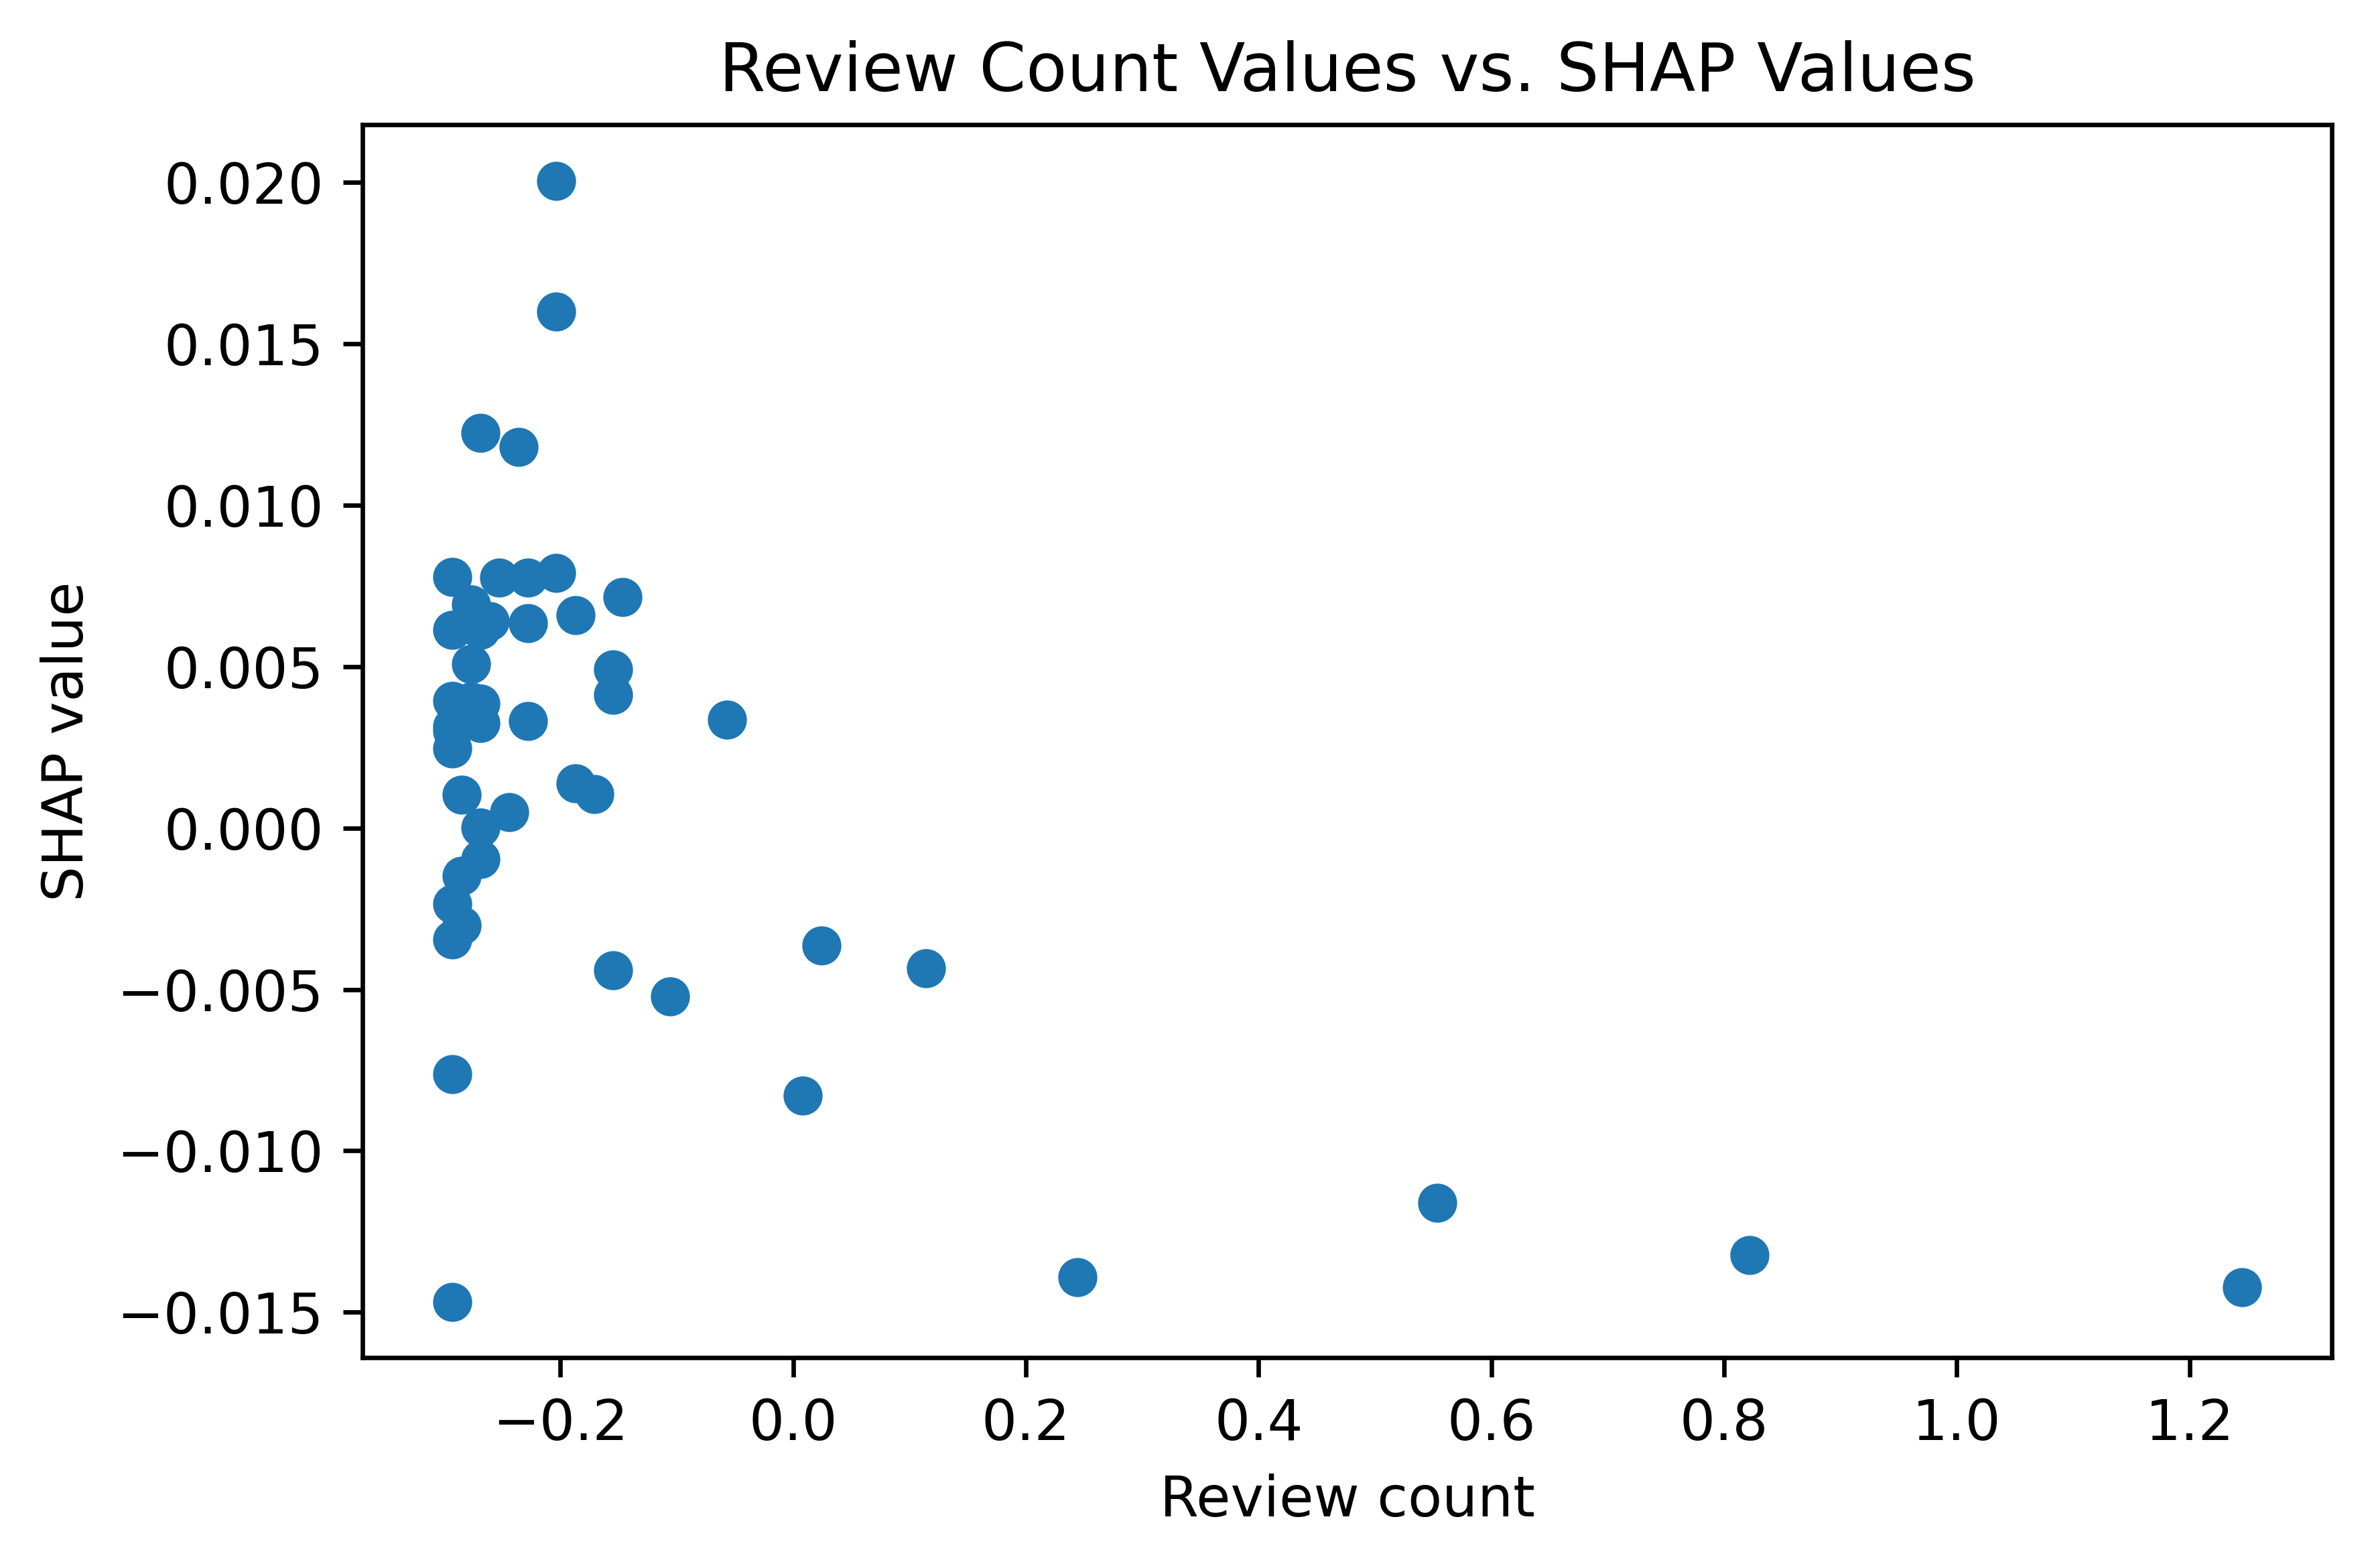

In [29]:
# Plot shap values of review count
plt.scatter(X_test_transformed[:50,446],shap_values[1][:,446])
plt.ylabel('SHAP value')
plt.xlabel('Review count')
plt.title('Review Count Values vs. SHAP Values')
plt.tight_layout()
#plt.savefig('../Figures/review-count-value-vs-SHAP-value.png', bbox_inches='tight')
plt.show()

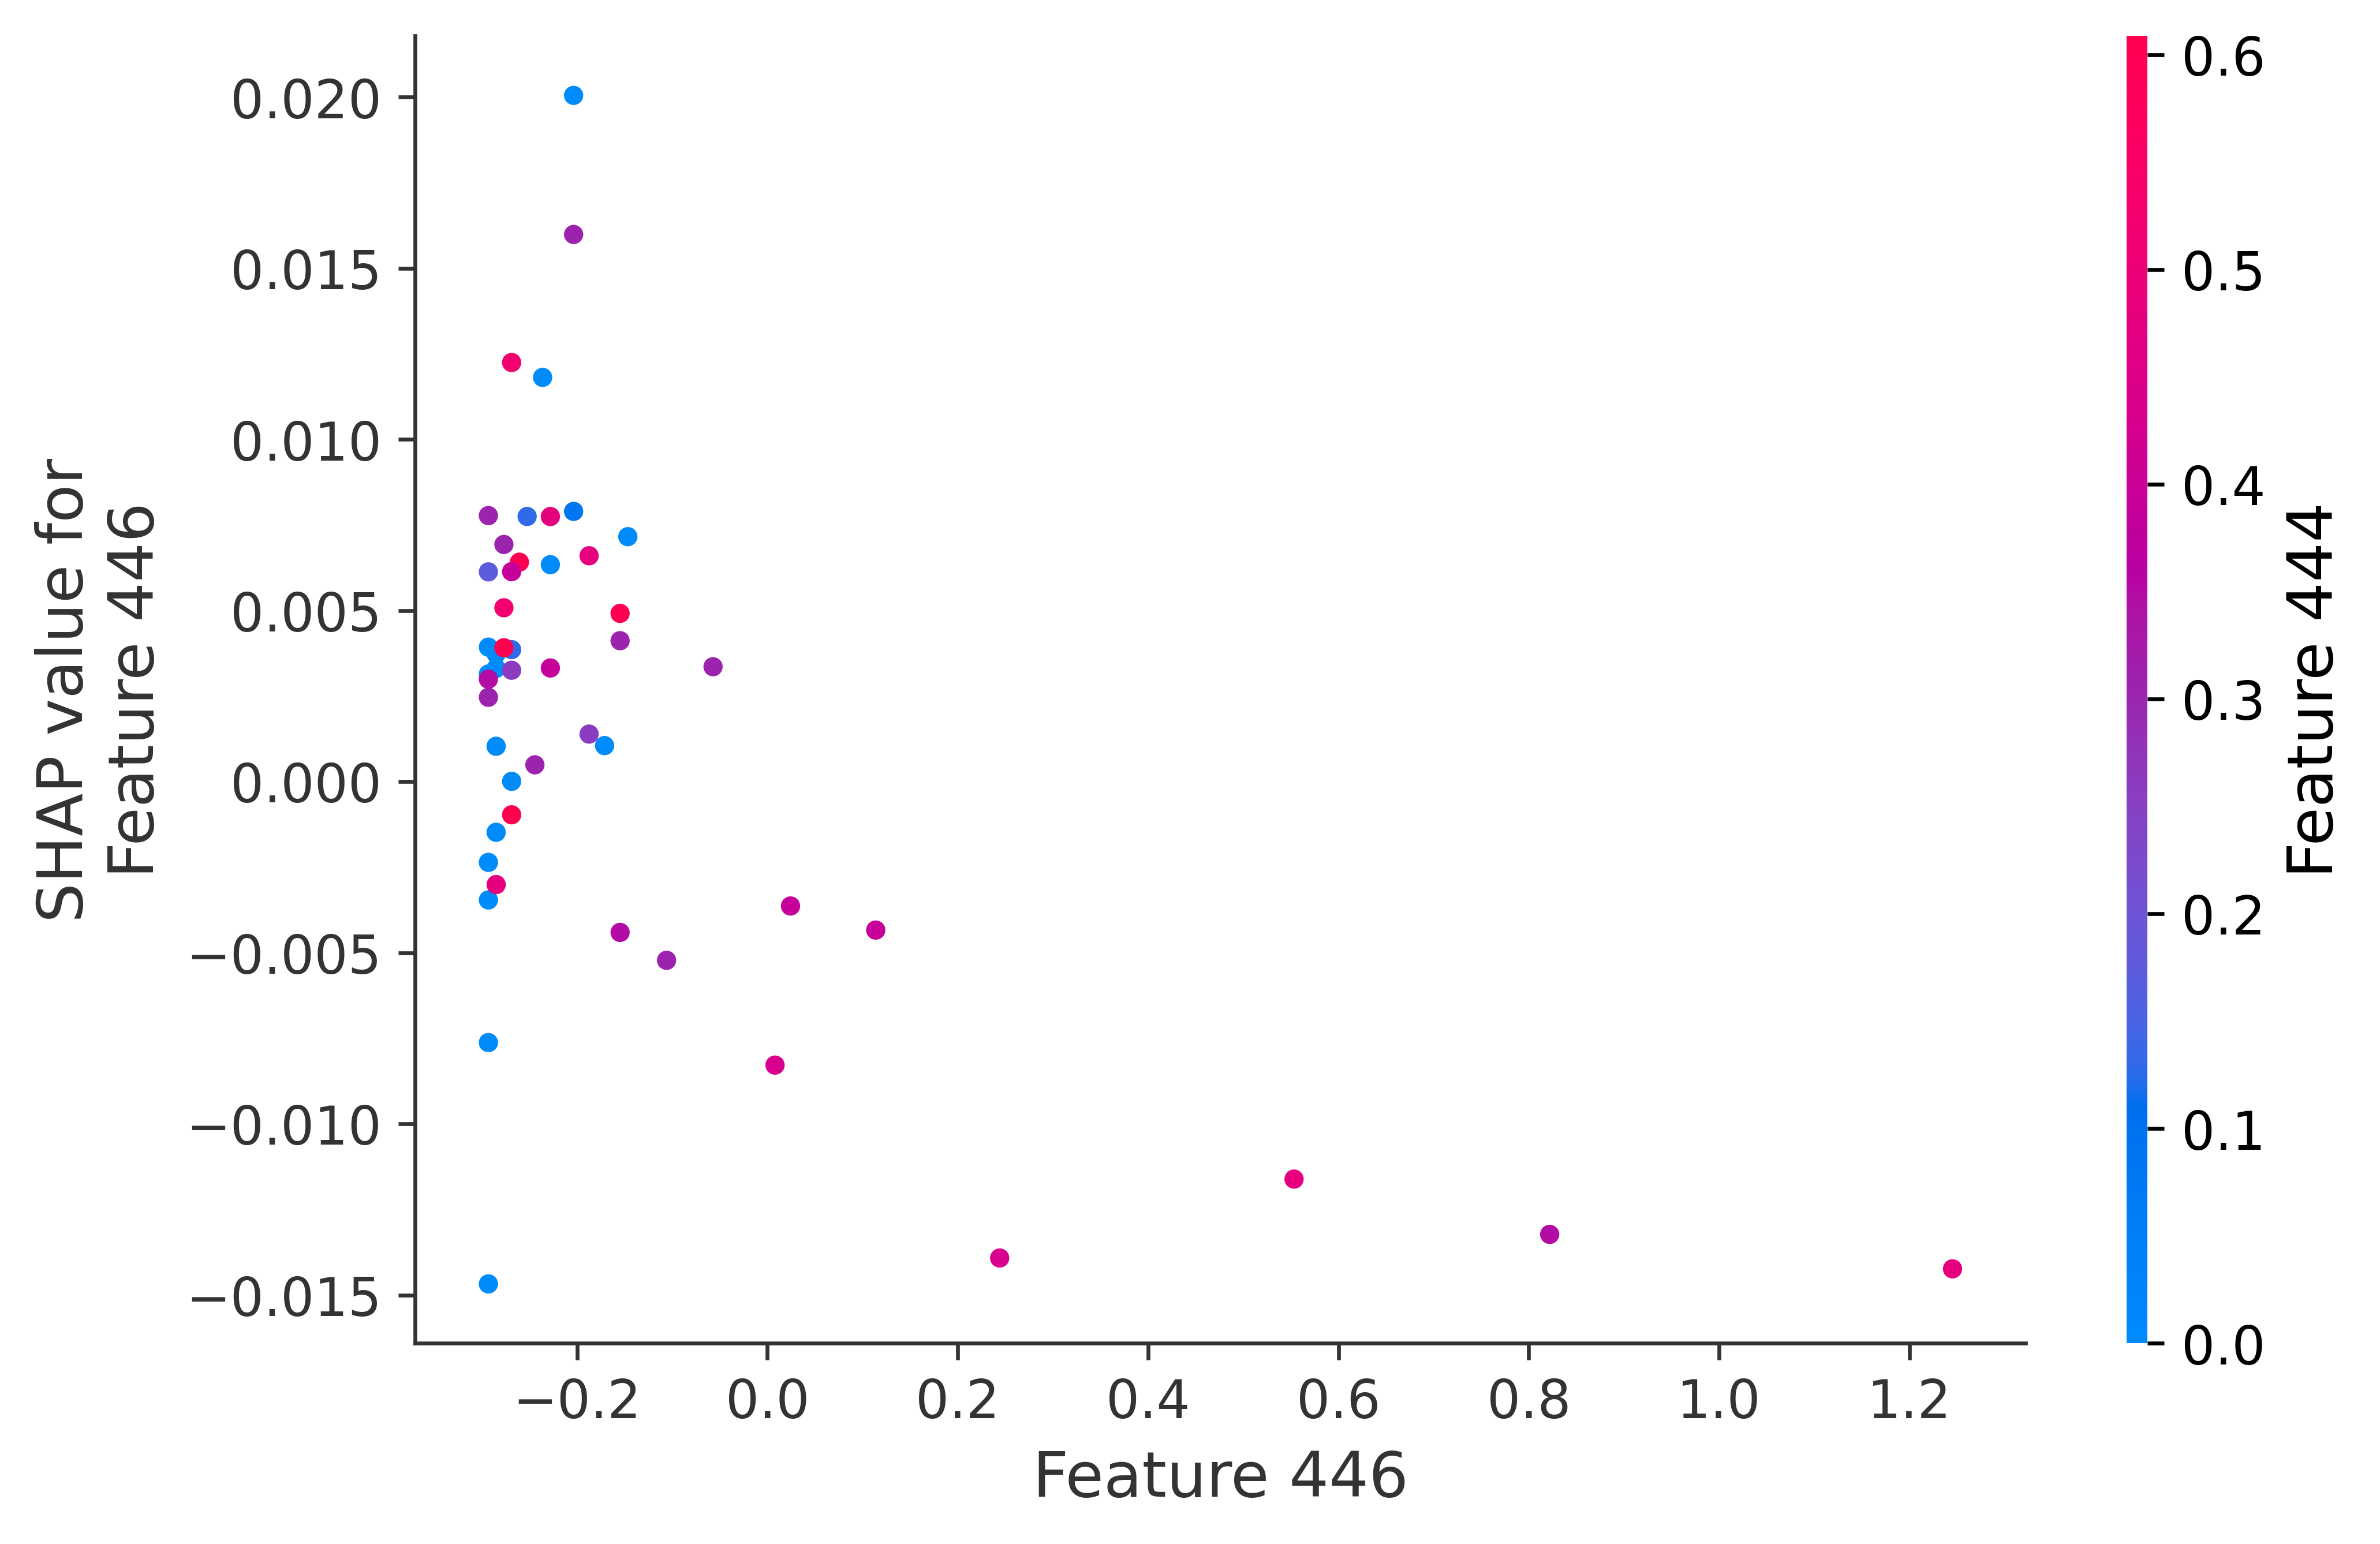

<Figure size 3600x2400 with 0 Axes>

In [30]:
# Dependence plot
shap.dependence_plot(446, shap_values[1], X_test_transformed[:50])
plt.tight_layout()
#plt.savefig('../Figures/SHAP-dependence.png', bbox_inches='tight')

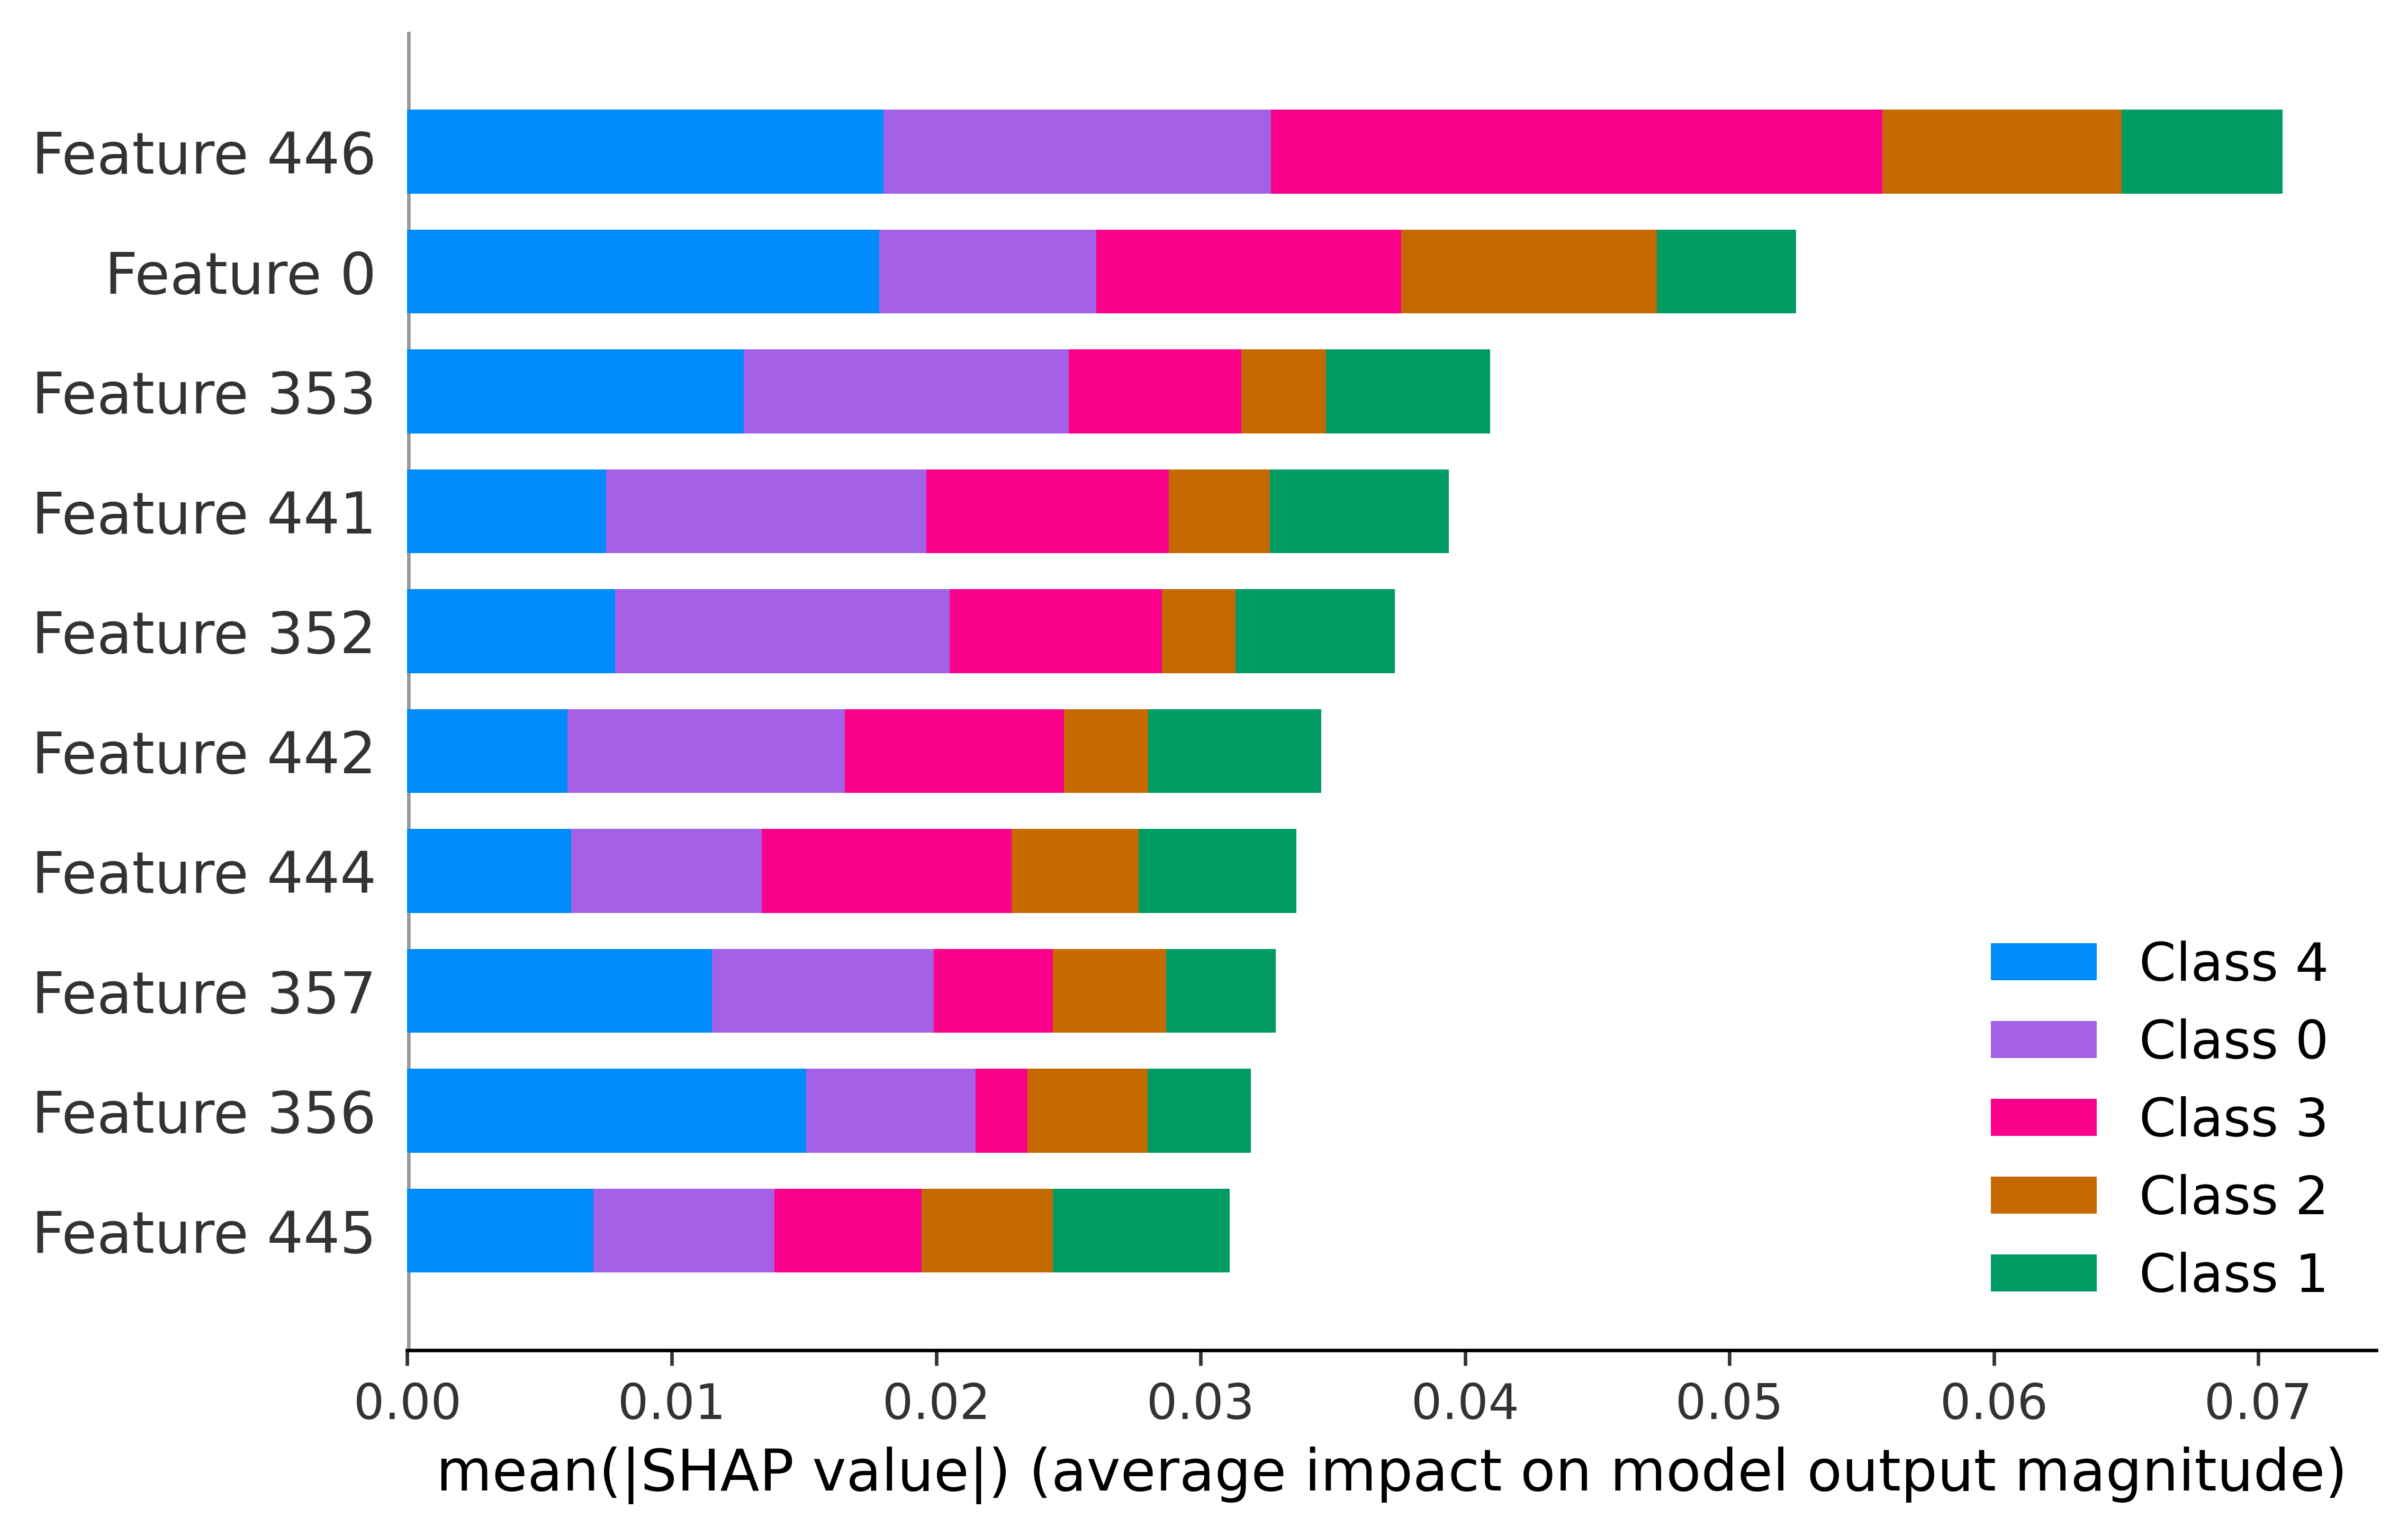

<Figure size 3600x2400 with 0 Axes>

In [31]:
# Global feature importance with SHAP
shap.summary_plot(shap_values, X_test_transformed[:50], max_display=10)
plt.tight_layout()
#plt.savefig('../Figures/SHAP-global-feature-importance.png', bbox_inches='tight')
plt.show()

# The Final Model

In [66]:
# Assume missingness in categorical features has already been accounted for but the data has not been split or preprocessed

final_models= []
test_scores = np.zeros(5)
f1s = []
saved_predictions = []

for i in range(0,5):
        
    np.random.seed(7*i)
        
    # Keep track of which random state we are in (total of 10)
    print("Random state ", i+1)

    # Stratified split of data: 90/10, no validation set for final computation
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y, random_state=7*i)
    #X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, stratify=y_other, random_state=7*i)
        
    # Transform categories column into list of lists composed of strings
    # We need this format in order to use MultiLabelBinarizer
    yelp_cat_train = X_train['categories']
    cat_col_train = []
    for row in yelp_cat_train:
        cat_col_train.append(row.split(', '))
    yelp_cat_test = X_test['categories']
    cat_col_test = []
    for row in yelp_cat_test:
        cat_col_test.append(row.split(', '))

    # Replace old categories column with the new one
    del X_train['categories']
    X_train.loc[:,"categories"] = cat_col_train
    del X_test['categories']
    X_test.loc[:,"categories"] = cat_col_test
        
    # Compute class weights for X_train
    train_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    weight_dict = {1: train_weights[0],
                   2: train_weights[1],
                   3: train_weights[2],
                   4: train_weights[3],
                   5: train_weights[4]}
    
    # Preprocess the data
    preprocessor = ColumnTransformer(
        transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_fts),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_fts),
        ('minmax', MinMaxScaler(), minmax_fts),
        ('std', StandardScaler(), std_fts),
        ('mlb', MultiHotEncoder(), mlb_fts)],
        n_jobs=-1)
    clf = Pipeline(steps=[('preprocessor', preprocessor)])

    # Fit transform
    X_train_prep = clf.fit_transform(X_train)
    #X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)

    # Extract feature names
    feature_names = preprocessor.transformers_[0][-1] + \
                    list(preprocessor.named_transformers_['onehot'].get_feature_names(onehot_fts)) + \
                    preprocessor.transformers_[2][-1] + \
                    preprocessor.transformers_[3][-1] + \
                    [item for sublist in preprocessor.named_transformers_['mlb'].categories_ for item in sublist]

    # Convert preprocessed sets to pandas data frames and label preprocessed features
    X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names)
    #X_val_prep = pd.DataFrame(X_val_prep, columns=feature_names)
    X_test_prep = pd.DataFrame(X_test_prep, columns=feature_names)
    
    # Drop least important features according to random forest classification Gini importance & permutation importance
    train_fts_drop = [x for x in poor_fts if x in X_train_prep.columns]
    test_fts_drop = [x for x in poor_fts if x in X_test_prep.columns]
    X_train_prep_reduced = X_train_prep.drop(train_fts_drop, axis=1)
    X_test_prep_reduced = X_test_prep.drop(test_fts_drop, axis=1)
    
    # Initialize the final classifier with best parameters
    rf_clf_final = RandomForestClassifier(random_state=7*i, 
                                          class_weight=weight_dict, 
                                          max_depth=60, 
                                          min_samples_split=8,
                                          n_jobs=1)
    
    # Fit the data
    rf_clf_final.fit(X_train_prep_reduced, y_train)
    
    # Save the models
    final_models.append(rf_clf_final)
    
    # Calculate test scores after model has been fitted
    y_test_pred = final_models[-1].predict(X_test_prep_reduced)
    saved_predictions.append(y_test_pred)
    test_scores[i] = f1_score(y_test, y_test_pred, average='weighted')
    print('Weighted F1 test score:', test_scores[i])
    print()
    print(confusion_matrix(y_test, y_test_pred))
    f1s.append(test_scores[i])
print("Mean of test scores: ", np.mean(f1s))
print("Standard deviation of test scores: ", np.std(f1s))

Random state  1


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Eritrean', 'Hang Gliding', 'Hearing Aids', 'Island Pub', 'Sport Equipment Hire', 'Street Art'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.45205131282892363

[[ 444  249  101   63  129]
 [ 540  915  839  320  324]
 [ 435  840 2327 1447  657]
 [ 264  383 1260 2905 1087]
 [ 183  104   98  490 1434]]
Random state  2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Catalan', 'Ceremonial Clothing', 'Christmas Markets', 'Electricity Suppliers', 'Sledding', 'Stonemasons'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.4480869366116119

[[ 450  251  103   59  123]
 [ 546  933  838  340  281]
 [ 416  830 2328 1437  695]
 [ 262  398 1314 2810 1115]
 [ 161  105  108  495 1440]]
Random state  3


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Bocce Ball', 'Catalan', 'Eritrean', 'Market Stalls', 'Mauritius', 'Stonemasons', 'Street Art'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.45027862480298203

[[ 453  271  103   45  114]
 [ 510  936  841  319  332]
 [ 453  855 2302 1449  647]
 [ 239  402 1309 2875 1074]
 [ 168   84  123  498 1436]]
Random state  4


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Experiences', 'Hang Gliding', 'Kitchen Incubators', 'Mauritius', 'Osteopaths'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.45443529154387663

[[ 431  286  104   40  125]
 [ 537  940  818  321  322]
 [ 428  879 2356 1364  679]
 [ 250  404 1208 2901 1136]
 [ 183   85  114  507 1420]]
Random state  5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Stonemasons', 'Street Art'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Weighted F1 test score: 0.45145741139891

[[ 412  274  124   53  123]
 [ 484  926  841  336  351]
 [ 446  864 2344 1386  666]
 [ 271  352 1267 2907 1102]
 [ 175   81  104  531 1418]]
Mean of test scores:  0.4512619154372609
Standard deviation of test scores:  0.0020870569633723254


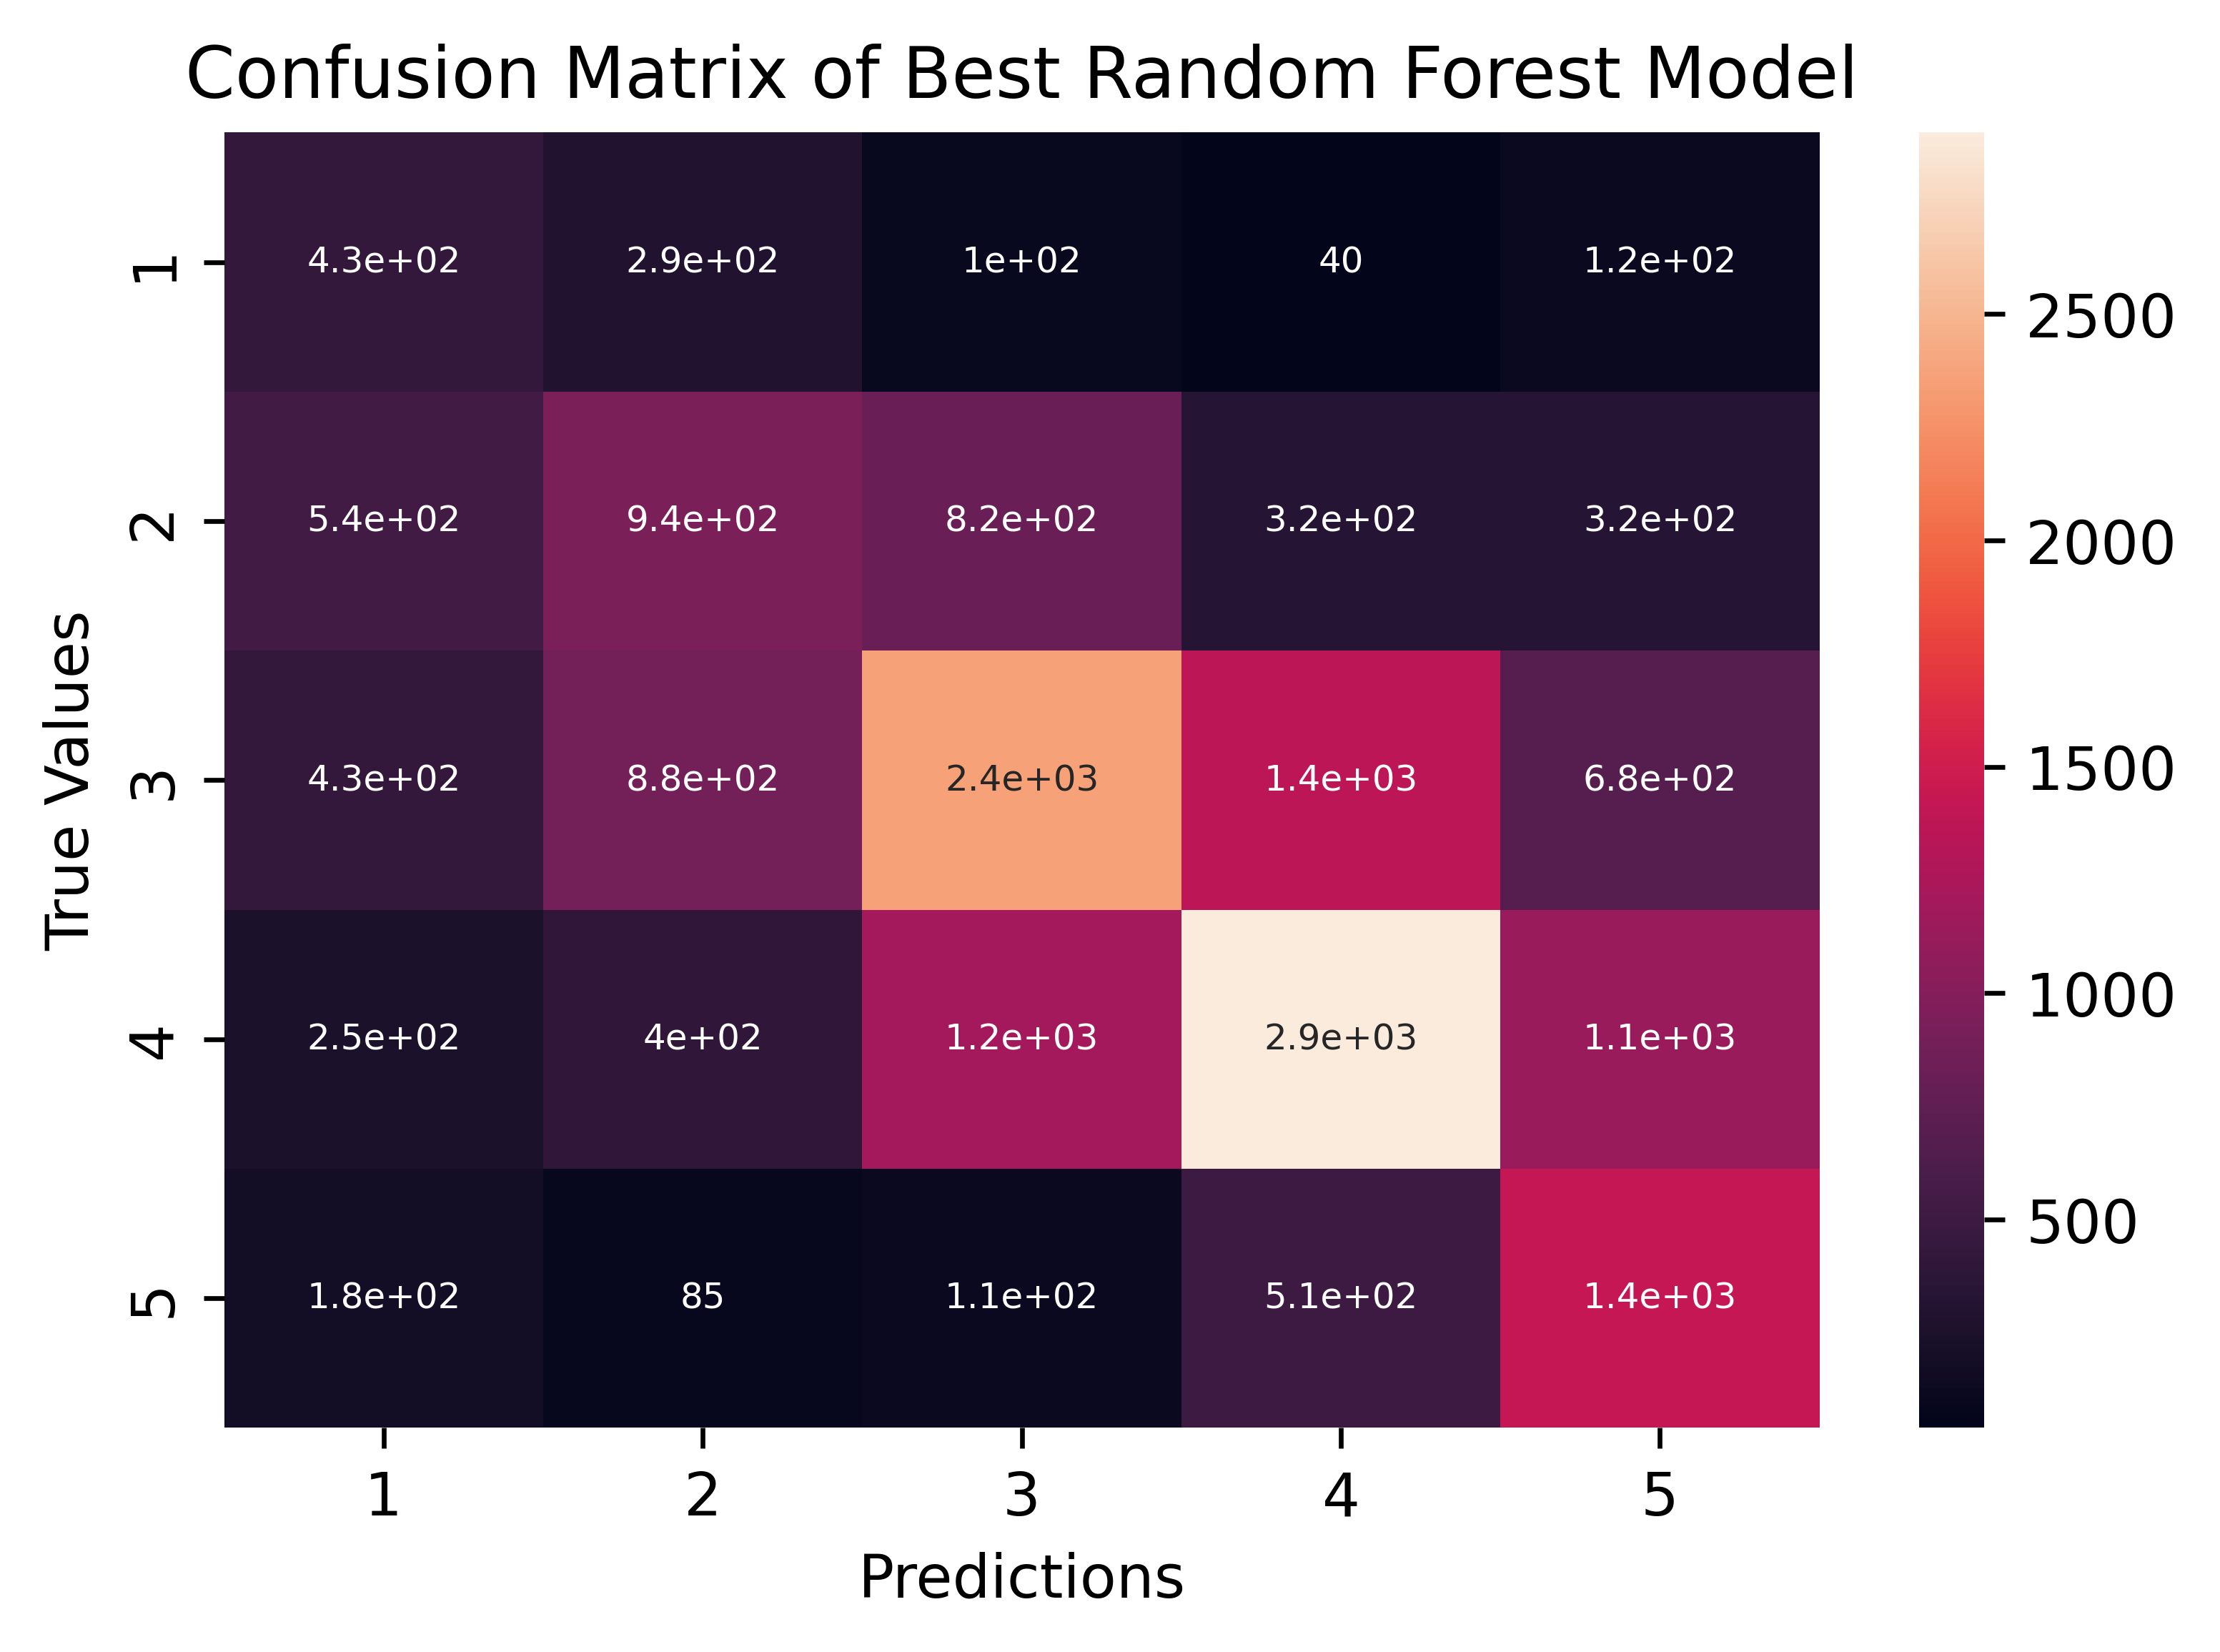

In [90]:
import seaborn as sn

# Plot best model confusion matrix
best_conf_mat = [[ 431,  286,  104,   40,  125],
                 [ 537,  940,  818,  321,  322],
                 [ 428,  879, 2356, 1364,  679],
                 [ 250,  404, 1208, 2901, 1136],
                 [ 183,   85,  114,  507,1420]]
classes = [1,2,3,4,5]
best_conf_mat_df = pd.DataFrame(best_conf_mat, index = [i for i in classes], columns = [i for i in classes])
ax = sn.heatmap(best_conf_mat_df, annot=True, annot_kws={"size": 6})
ax.set(xlabel='Predictions', ylabel='True Values', title='Confusion Matrix of Best Random Forest Model')
#plt.savefig('../Figures/confusion_matrix_rf.png', bbox_inches='tight')
# Save best confusion matrix
with open('../results/best_conf_mat.obj', 'wb') as file:
    pickle.dump(best_conf_mat_df, file)
file.close()

In [228]:
# Save f1 scores, final models, and predictions
best_model_ind = f1s.index(max(f1s))

with open('../results/best_model.obj', 'wb') as file:
    pickle.dump(final_models[best_model_ind], file)
file.close()

with open('../results/best_f1.obj', 'wb') as file:
    pickle.dump(f1s[best_model_ind], file)
file.close()

with open('../results/best_predictions.obj', 'wb') as file:
    pickle.dump(saved_predictions[best_model_ind], file)
file.close()